In [1]:
!pip install MissForest

In [2]:
!pip install ydata-profiling


In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import missingno as msno
from scipy.stats import chi2_contingency
from missforest import MissForest
import ydata_profiling as pp

In [4]:
df = pd.read_excel("/content/side_effect_data 1.xlsx")

In [5]:
def grab_col_names(dataframe, cat_th=11, car_th=30):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal deðiþkenlerin isimlerini verir.
    Not: Kategorik deðiþkenlerin içerisine numerik görünümlü kategorik deðiþkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Deðiþken isimleri alýnmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan deðiþkenler için sýnýf eþik deðeri
        car_th: int, optinal
                kategorik fakat kardinal deðiþkenler için sýnýf eþik deðeri

    Returns
    ------
        cat_cols: list
                Kategorik deðiþken listesi
        num_cols: list
                Numerik deðiþken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal deðiþken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam deðiþken sayýsý
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamý toplam deðiþken sayýsýna eþittir: cat_cols + num_cols + cat_but_car = deðiþken sayýsý

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2357
Variables: 19
cat_cols: 6
num_cols: 7
cat_but_car: 6
num_but_cat: 0


In [6]:
# Outlier Analysis
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

# Missing Values

df.isnull().values.any()
df.isnull().sum()

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df, True)

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Kullanici_id False
Dogum_Tarihi False
Ilac_Baslangic_Tarihi False
Ilac_Bitis_Tarihi False
Yan_Etki_Bildirim_Tarihi False
Kilo False
Boy False
                                  n_miss  ratio
Cinsiyet                             778  33.01
Alerjilerim                          484  20.53
Kronik Hastaliklarim                 392  16.63
Kan Grubu                            347  14.72
Kilo                                 293  12.43
Il                                   227   9.63
Anne Kronik Hastaliklari             217   9.21
Baba Kronik Hastaliklari             156   6.62
Erkek Kardes Kronik Hastaliklari     121   5.13
Boy                                  114   4.84
Kiz Kardes Kronik Hastaliklari        97   4.12


In [7]:
def check_missing_values(df):
    """
    Check for missing values in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    pd.Series: A series with the count of missing values per column.
    """
    return df.isnull().sum()
def check_duplicates(df):
    """
    Check for duplicate rows in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    int: The count of duplicate rows.
    """
    return df.duplicated().sum()

def validate_value_ranges(df):
    """
    Validate the range of values in all numeric columns of the DataFrame
    using the minimum and maximum values from those columns.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    dict: A dictionary with column names as keys and boolean Series as values indicating validity.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = {}

    for column in numeric_cols:
        # Get min and max for the current column
        min_value = df[column].min()
        max_value = df[column].max()

        # Validate against the min and max values
        valid_min = df[column] >= min_value
        valid_max = df[column] <= max_value
        results[column] = valid_min & valid_max

    return results

def check_unique_values(df):
    """
    Check the unique values in all columns of the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    dict: A dictionary with column names as keys and unique values as values.
    """
    unique_values = {}
    for column in df.columns:
        unique_values[column] = df[column].unique()
    return unique_values


check_missing_values(df)
check_duplicates(df)
validate_value_ranges(df)
check_unique_values(df)

{'Kullanici_id': array([107, 140,   2,  83,   7, 131,  61,  95,   3,  53,  81, 108, 121,
         33, 194,  42, 182, 189, 156, 113, 134,  36, 180,  55, 165, 174,
        161,  20,  90, 111, 188, 187, 169, 154,  21, 106, 110,  66,  39,
         73, 155,  29, 101, 168, 124, 160, 115,  92,  54,  99,  69,  10,
         41,  94,  15,  19, 159, 128,  34, 175,  93, 167, 190,  88,  70,
         59,  85,  35, 141, 127,  49,  72,  17, 195,  65, 183,  62,   6,
         80, 132, 138,  45, 117, 133,  91,  47, 112, 118, 166,  25, 129,
          8,  82, 100, 170, 120,  84,  16,  31, 196, 122,  50, 192,  57,
        179,  26, 181, 102, 152,  37, 162, 135,  52,  11, 163,  71,  56,
         68, 139,  63, 171, 176, 185,  89,   4,  98,  51,  38,  13,  79,
         64,  28,  22, 105, 137,  77,  32, 126,  75, 116, 149, 157, 114,
         58, 109,  48, 147,   9, 186,  14, 145,  76,  97, 178,  96,  12,
        144,  74, 130,  78, 158,   1, 103,  40, 164,  18, 136, 151,   5,
         67,  86,  44, 146, 123, 19

In [8]:
profile = pp.ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

          Cinsiyet      Ratio
Cinsiyet                     
Female         872  36.996182
Male           707  29.995757
##########################################
         Uyruk  Ratio
Uyruk                
Turkiye   2357  100.0
##########################################
            Il     Ratio
Il                      
Adana      220  9.333899
Mersin     207  8.782350
Trabzon    195  8.273229
Canakkale  179  7.594400
Ankara     179  7.594400
Eskisehir  174  7.382266
Antalya    171  7.254985
Bursa      169  7.170132
Samsun     153  6.491303
Istanbul   144  6.109461
Izmir      121  5.133644
Malatya    109  4.624523
Kayseri    109  4.624523
##########################################
                       Yan_Etki     Ratio
Yan_Etki                                 
Agizda Farkli Bir Tat       229  9.715740
Tansiyon Yukselme           227  9.630887
Yorgunluk                   204  8.655070
Gormede Bulaniklik          170  7.212558
Kabizlik                    156  6.618583
Ishal           

In [10]:
def perform_eda(df):
    """
    Perform basic Exploratory Data Analysis (EDA) on a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    None
    """

    # 1. Basic Data Info
    print("----- Data Overview -----")
    print(f"Shape of DataFrame: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isnull().sum())

    # 2. Descriptive Statistics
    print("\n----- Descriptive Statistics -----")
    print(df.describe())

    # 3. Data Visualization - Distribution of numeric columns
    print("\n----- Visualizations -----")
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f"Distribution of {column}")
        plt.show()

    # 4. Correlation Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # 5. Handling Missing Data
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    if not missing_data.empty:
        print("\n----- Handling Missing Data -----")
        print(f"Missing values in columns:\n{missing_data}")
        # Here you can decide to drop or fill missing values based on specific logic
        df_cleaned = df.dropna()  # For simplicity, we drop rows with missing data
        print(f"Shape after dropping missing data: {df_cleaned.shape}")
    else:
        print("\nNo missing data found.")

    # 6. Value Counts for Categorical Columns
    print("\n----- Categorical Value Counts -----")
    for column in df.select_dtypes(include=['object']).columns:
        print(f"\nValue counts for {column}:")
        print(df[column].value_counts())

    # 7. Outlier Detection via Boxplot
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[column])
        plt.title(f"Boxplot for {column}")
        plt.show()

    # 8. Pairwise Relationships for Numeric Columns
    plt.figure(figsize=(10, 8))
    sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
    plt.suptitle("Pairwise Relationships", y=1.02)
    plt.show()

In [11]:
def analyze_dataframe(df):
    # Check for missing values
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()

    print("\n--- Missing Values Analysis ---")
    if total_missing == 0:
        print("No missing values in the DataFrame.")
    else:
        print(f"Total missing values in the DataFrame: {total_missing}")
        print("Missing values by column:")
        print(missing_values[missing_values > 0].sort_values(ascending=False))

    # Summary statistics for numeric columns
    print("\n--- Summary Statistics ---")
    summary_stats = df.describe()
    print(summary_stats)

    # Additional check for categorical columns
    print("\n--- Categorical Columns Info ---")
    for col in df.select_dtypes(include=['object', 'category']):
        unique_count = df[col].nunique()
        print(f"Column '{col}': {unique_count} unique values")
analyze_dataframe(df)


--- Missing Values Analysis ---
Total missing values in the DataFrame: 3226
Missing values by column:
Cinsiyet                            778
Alerjilerim                         484
Kronik Hastaliklarim                392
Kan Grubu                           347
Kilo                                293
Il                                  227
Anne Kronik Hastaliklari            217
Baba Kronik Hastaliklari            156
Erkek Kardes Kronik Hastaliklari    121
Boy                                 114
Kiz Kardes Kronik Hastaliklari       97
dtype: int64

--- Summary Statistics ---
       Kullanici_id                   Dogum_Tarihi  \
count   2357.000000                           2357   
mean      97.216801  1974-11-25 04:06:12.677131936   
min        1.000000            1939-10-12 00:00:00   
25%       47.000000            1959-02-05 00:00:00   
50%       97.000000            1973-09-09 00:00:00   
75%      146.000000            1992-03-24 00:00:00   
max      196.000000            2011-04


--- Analysis of 'Cinsiyet' ---

Value Counts:
Cinsiyet
Female    872
Male      707
Name: count, dtype: int64

Percentage Distribution:
Cinsiyet
Female    55.22%
Male      44.78%
Name: proportion, dtype: object

Missing Values: 778

Number of Unique Values: 2


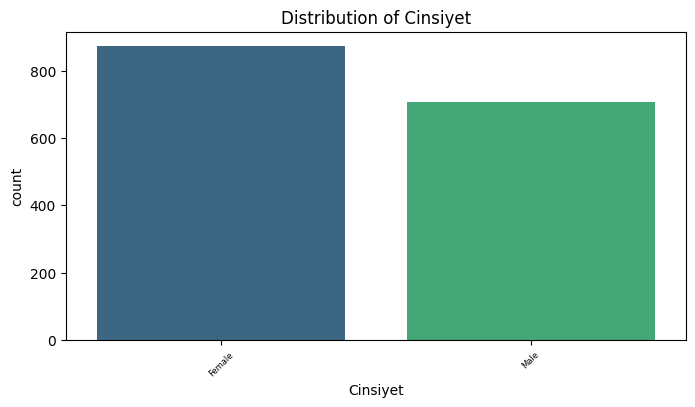


--- Analysis of 'Uyruk' ---

Value Counts:
Uyruk
Turkiye    2357
Name: count, dtype: int64

Percentage Distribution:
Uyruk
Turkiye    100.0%
Name: proportion, dtype: object

Missing Values: 0

Number of Unique Values: 1


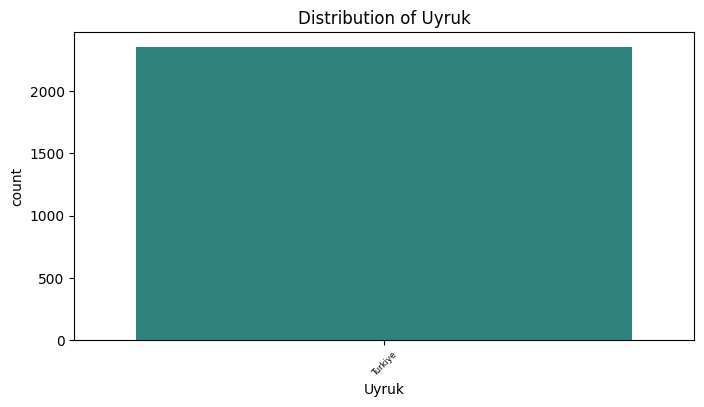


--- Analysis of 'Il' ---

Value Counts:
Il
Adana        220
Mersin       207
Trabzon      195
Canakkale    179
Ankara       179
Eskisehir    174
Antalya      171
Bursa        169
Samsun       153
Istanbul     144
Izmir        121
Malatya      109
Kayseri      109
Name: count, dtype: int64

Percentage Distribution:
Il
Adana        10.33%
Mersin        9.72%
Trabzon       9.15%
Canakkale      8.4%
Ankara         8.4%
Eskisehir     8.17%
Antalya       8.03%
Bursa         7.93%
Samsun        7.18%
Istanbul      6.76%
Izmir         5.68%
Malatya       5.12%
Kayseri       5.12%
Name: proportion, dtype: object

Missing Values: 227

Number of Unique Values: 13


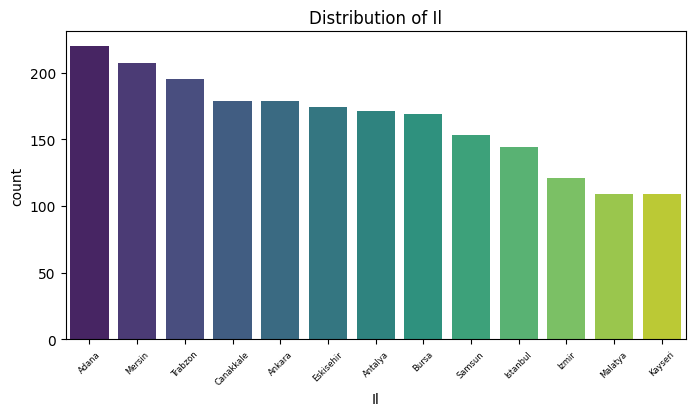


--- Analysis of 'Ilac_Adi' ---

Value Counts:
Ilac_Adi
chlordiazepoxide-amitriptyline                             29
lurasidone                                                 27
hydrocortisone cream                                       27
loxapine                                                   26
desvenlafaxine succinate tablet, extended release 24 hr    26
                                                           ..
risperdal consta syringe                                    8
pethidine hcl                                               8
citalopram                                                  8
desoximetasone ointment                                     8
lithium carbonate                                           7
Name: count, Length: 151, dtype: int64

Percentage Distribution:
Ilac_Adi
chlordiazepoxide-amitriptyline                             1.23%
lurasidone                                                 1.15%
hydrocortisone cream                                      

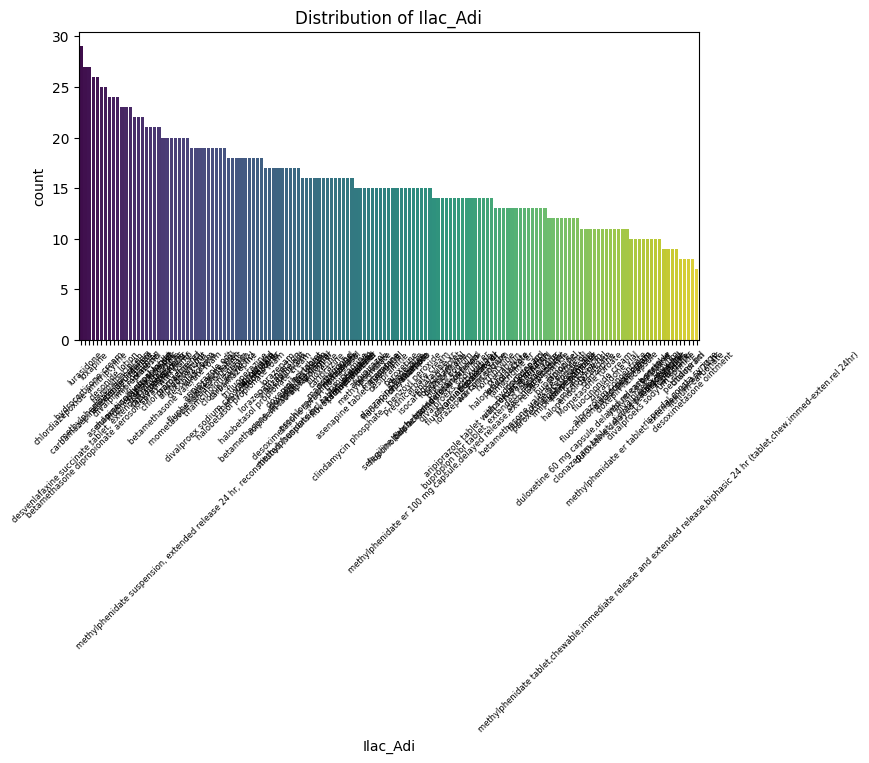


--- Analysis of 'Yan_Etki' ---

Value Counts:
Yan_Etki
Agizda Farkli Bir Tat    229
Tansiyon Yukselme        227
Yorgunluk                204
Gormede Bulaniklik       170
Kabizlik                 156
Ishal                    145
Az Uyuma                 141
Terleme                   97
Sinirlilik                81
Gec Bosalma               81
Gucsuzluk                 81
Mide Bulantisi            80
Tansiyon Dusuklugu        74
Carpinti                  72
Istah Artisi              71
Bas Agrisi                71
Karin Agrisi              69
Uykululuk Hali            68
Bulanti                   64
Huzursuzluk               63
Kas Agrisi                58
Deride Morarma            55
Name: count, dtype: int64

Percentage Distribution:
Yan_Etki
Agizda Farkli Bir Tat    9.72%
Tansiyon Yukselme        9.63%
Yorgunluk                8.66%
Gormede Bulaniklik       7.21%
Kabizlik                 6.62%
Ishal                    6.15%
Az Uyuma                 5.98%
Terleme                  4.1

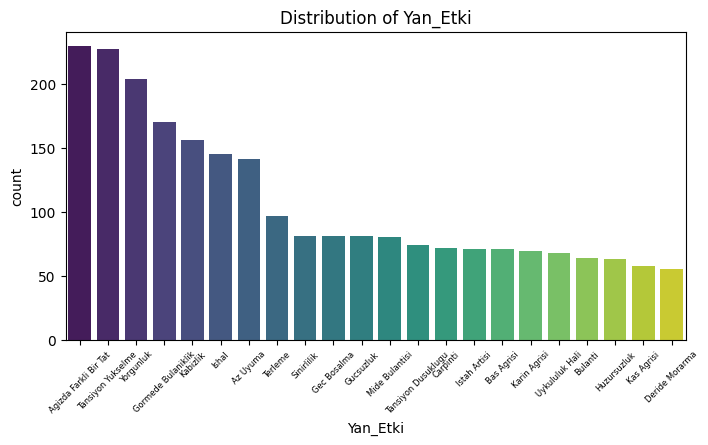


--- Analysis of 'Alerjilerim' ---

Value Counts:
Alerjilerim
Domates            118
Karaciger          109
Pancar             100
Balik               98
Havyar              97
Ispanakgiller       95
Kopek               91
Kefir               91
Yogurt              89
Deniz Urunler       87
Muz                 81
Kabak Cekirdegi     77
Kahve               76
Sari Kantaron       75
Toz                 70
Laktoz              60
Bugday              55
Cikolata            53
Elma                53
Ispanak             48
Istiridye           46
Bal                 43
Kedi                38
Lateks              32
Ceviz               30
Sut                 27
Kakao               22
Kolali Icecek       12
Name: count, dtype: int64

Percentage Distribution:
Alerjilerim
Domates             6.3%
Karaciger          5.82%
Pancar             5.34%
Balik              5.23%
Havyar             5.18%
Ispanakgiller      5.07%
Kopek              4.86%
Kefir              4.86%
Yogurt             4.75%
Deniz

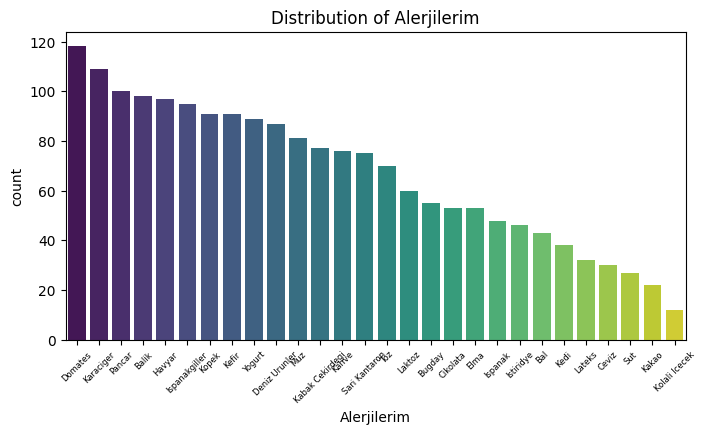


--- Analysis of 'Kronik Hastaliklarim' ---

Value Counts:
Kronik Hastaliklarim
Alzheimer, Diger                   61
Kan Hastaliklari, Hipertansiyon    58
Alzheimer, Astim                   57
KOAH, Guatr                        55
Kemik Erimesi, Kan Hastaliklari    48
                                   ..
Astim, Guatr                        8
Astim, Kan Hastaliklari             7
Hipertansiyon, Alzheimer            7
Kanser, Kan Hastaliklari            6
Astim                               3
Name: count, Length: 80, dtype: int64

Percentage Distribution:
Kronik Hastaliklarim
Alzheimer, Diger                    3.1%
Kan Hastaliklari, Hipertansiyon    2.95%
Alzheimer, Astim                    2.9%
KOAH, Guatr                         2.8%
Kemik Erimesi, Kan Hastaliklari    2.44%
                                   ...  
Astim, Guatr                       0.41%
Astim, Kan Hastaliklari            0.36%
Hipertansiyon, Alzheimer           0.36%
Kanser, Kan Hastaliklari           0.31%
Astim  

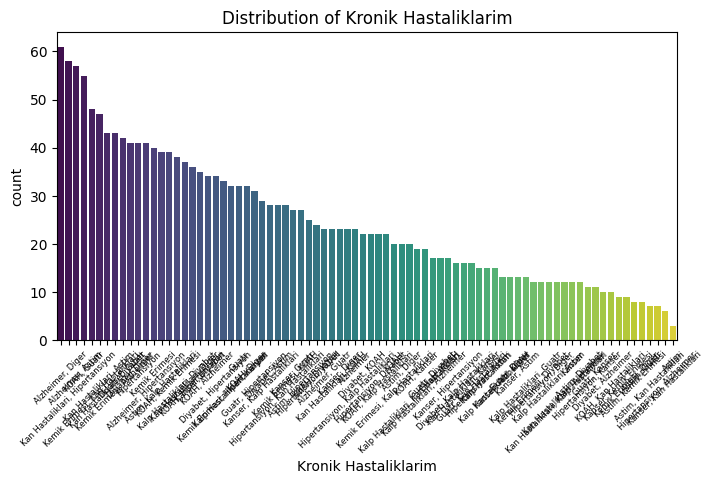


--- Analysis of 'Baba Kronik Hastaliklari' ---

Value Counts:
Baba Kronik Hastaliklari
Alzheimer, Diyabet                     64
Kanser                                 62
                                       55
Alzheimer                              53
Kalp Hastaliklari, Kan Hastaliklari    51
                                       ..
KOAH, Astim                             9
Astim, KOAH                             9
Kanser, Hipertansiyon                   9
Astim                                   8
KOAH, Alzheimer                         6
Name: count, Length: 92, dtype: int64

Percentage Distribution:
Baba Kronik Hastaliklari
Alzheimer, Diyabet                     2.91%
Kanser                                 2.82%
                                        2.5%
Alzheimer                              2.41%
Kalp Hastaliklari, Kan Hastaliklari    2.32%
                                       ...  
KOAH, Astim                            0.41%
Astim, KOAH                            0.41%
K

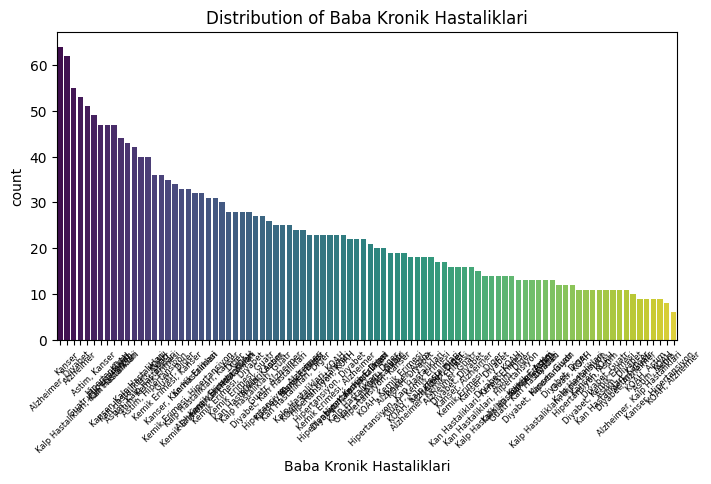


--- Analysis of 'Anne Kronik Hastaliklari' ---

Value Counts:
Anne Kronik Hastaliklari
Alzheimer, Astim                   110
KOAH                                70
                                    65
Kanser, Guatr                       61
Kemik Erimesi, Kan Hastaliklari     58
                                  ... 
Kan Hastaliklari, Hipertansiyon      8
Astim, Diyabet                       8
KOAH, Kemik Erimesi                  8
Diyabet, Kalp Hastaliklari           6
Kemik Erimesi, Kanser                3
Name: count, Length: 84, dtype: int64

Percentage Distribution:
Anne Kronik Hastaliklari
Alzheimer, Astim                   5.14%
KOAH                               3.27%
                                   3.04%
Kanser, Guatr                      2.85%
Kemik Erimesi, Kan Hastaliklari    2.71%
                                   ...  
Kan Hastaliklari, Hipertansiyon    0.37%
Astim, Diyabet                     0.37%
KOAH, Kemik Erimesi                0.37%
Diyabet, Kalp Hastaliklar

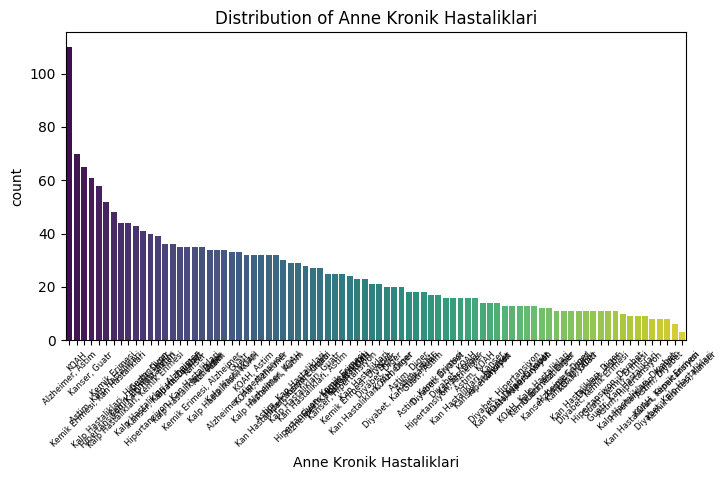


--- Analysis of 'Kiz Kardes Kronik Hastaliklari' ---

Value Counts:
Kiz Kardes Kronik Hastaliklari
                                    168
Kanser, Hipertansiyon                70
Alzheimer, Astim                     61
Kanser                               61
Guatr                                59
                                   ... 
Diyabet, Astim                        9
Kemik Erimesi, Kanser                 8
Hipertansiyon, Diyabet                8
Hipertansiyon, Kalp Hastaliklari      6
Astim, Kanser                         6
Name: count, Length: 85, dtype: int64

Percentage Distribution:
Kiz Kardes Kronik Hastaliklari
                                    7.43%
Kanser, Hipertansiyon                3.1%
Alzheimer, Astim                     2.7%
Kanser                               2.7%
Guatr                               2.61%
                                    ...  
Diyabet, Astim                       0.4%
Kemik Erimesi, Kanser               0.35%
Hipertansiyon, Diyabet       

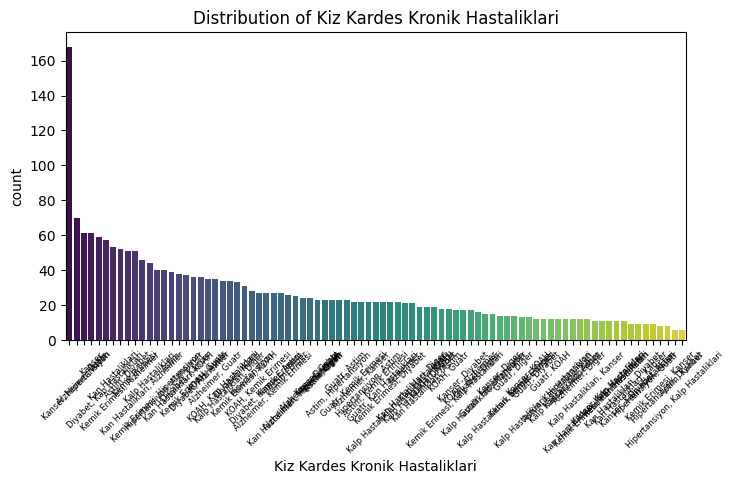


--- Analysis of 'Erkek Kardes Kronik Hastaliklari' ---

Value Counts:
Erkek Kardes Kronik Hastaliklari
                                   136
Kemik Erimesi                       71
Diger                               68
Alzheimer, Astim                    51
Alzheimer                           49
                                  ... 
Diyabet                              9
Kanser, Diyabet                      9
Hipertansiyon, KOAH                  8
Guatr                                8
Hipertansiyon, Kan Hastaliklari      6
Name: count, Length: 90, dtype: int64

Percentage Distribution:
Erkek Kardes Kronik Hastaliklari
                                   6.08%
Kemik Erimesi                      3.18%
Diger                              3.04%
Alzheimer, Astim                   2.28%
Alzheimer                          2.19%
                                   ...  
Diyabet                             0.4%
Kanser, Diyabet                     0.4%
Hipertansiyon, KOAH                0.36%
G

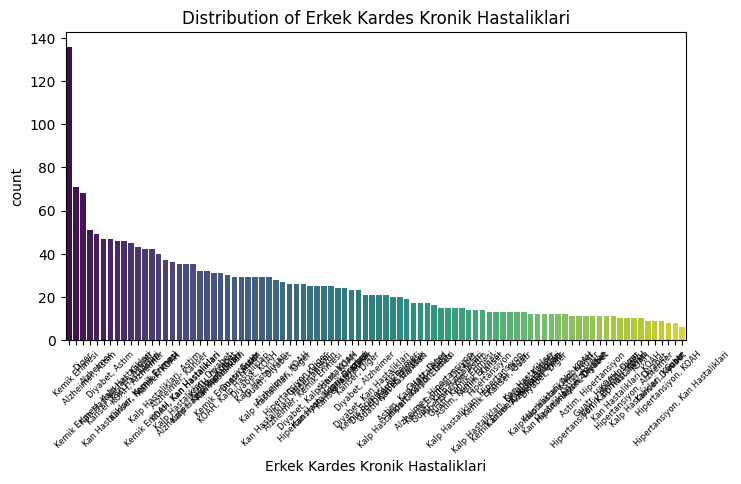


--- Analysis of 'Kan Grubu' ---

Value Counts:
Kan Grubu
AB RH-    421
0 RH+     275
B RH+     256
AB RH+    250
B RH-     233
0 RH-     232
A RH+     198
A RH-     145
Name: count, dtype: int64

Percentage Distribution:
Kan Grubu
AB RH-    20.95%
0 RH+     13.68%
B RH+     12.74%
AB RH+    12.44%
B RH-     11.59%
0 RH-     11.54%
A RH+      9.85%
A RH-      7.21%
Name: proportion, dtype: object

Missing Values: 347

Number of Unique Values: 8


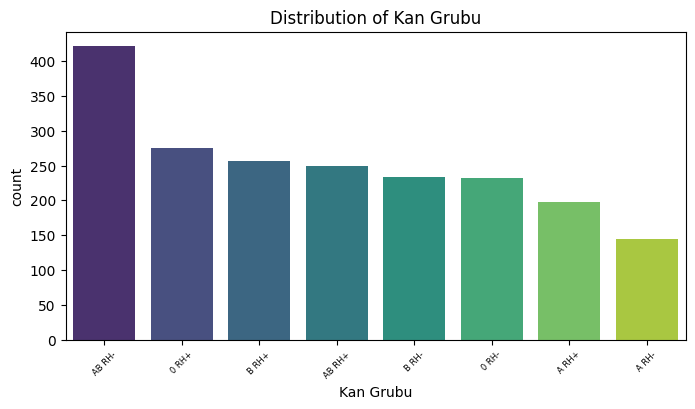

In [12]:
def analyze_categorical_columns(df):
    """
    Perform column-wise analysis on categorical columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame

    Returns:
    None
    """
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        print(f"\n--- Analysis of '{col}' ---")

        # 1. Value Counts
        print("\nValue Counts:")
        print(df[col].value_counts())

        # 2. Percentage Distribution
        print("\nPercentage Distribution:")
        print((df[col].value_counts(normalize=True) * 100).round(2).astype(str) + '%')

        # 3. Missing Values
        missing_count = df[col].isnull().sum()
        print(f"\nMissing Values: {missing_count}")

        # 4. Unique Values
        unique_count = df[col].nunique()
        print(f"\nNumber of Unique Values: {unique_count}")

        # 5. Visualize the Distribution
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
        plt.title(f'Distribution of {col}')
        plt.xticks(fontsize=6)
        plt.xticks(rotation=45)
        plt.show()

analyze_categorical_columns(df)

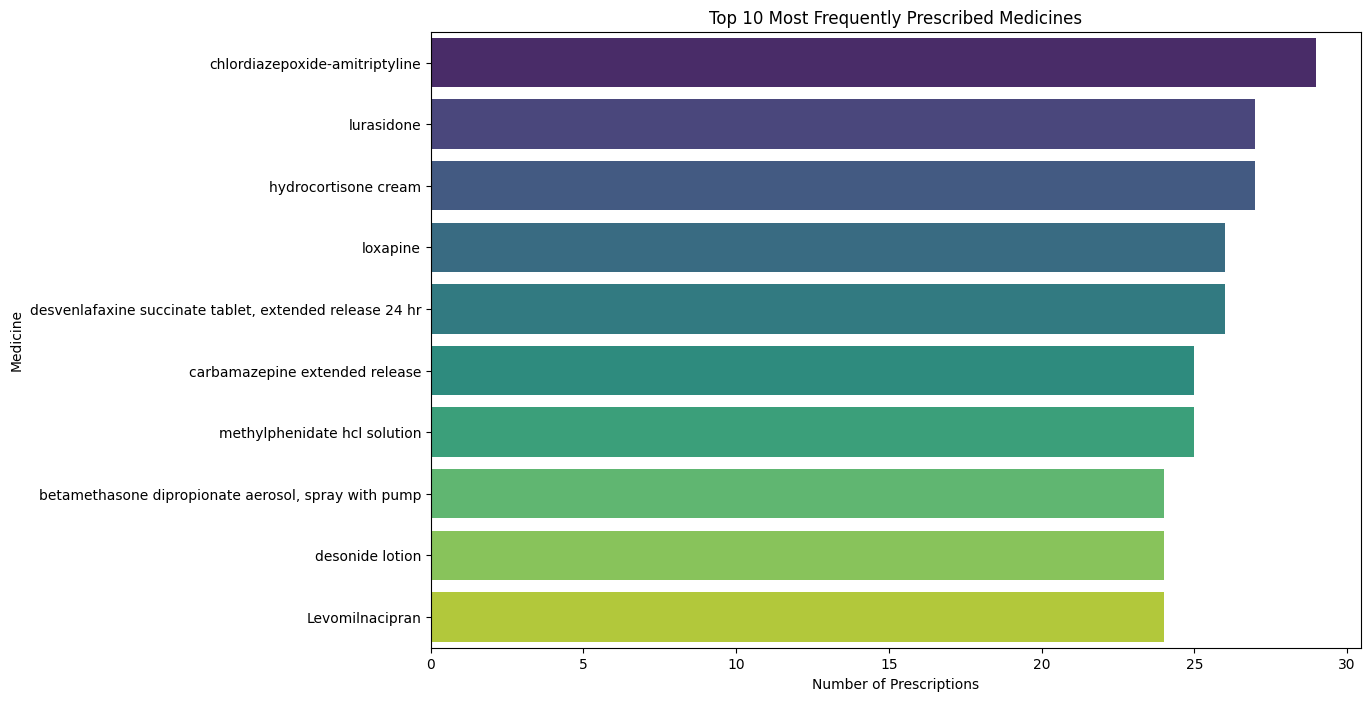

In [13]:
def plot_top_medicines(df, medicine_col, top_n=10):
    """
    Plot the top N most frequently prescribed medicines based on their counts.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    medicine_col (str): The column name for medicines
    top_n (int): Number of top medicines to display

    Returns:
    None
    """
    # Count occurrences of each medicine
    medicine_counts = df[medicine_col].value_counts()

    # Get the top N medicines
    top_medicines = medicine_counts.head(top_n).reset_index()
    top_medicines.columns = [medicine_col, 'Count']

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y=medicine_col, data=top_medicines, palette="viridis")
    plt.title(f'Top {top_n} Most Frequently Prescribed Medicines')
    plt.xlabel('Number of Prescriptions')
    plt.ylabel('Medicine')
    plt.show()

# Example usage:

plot_top_medicines(df, 'Ilac_Adi')



Categorical Columns: ['Cinsiyet', 'Uyruk', 'Il', 'Yan_Etki', 'Alerjilerim', 'Kan Grubu']

Frequency Distribution of 'Cinsiyet':
Cinsiyet
Female    872
Male      707
Name: count, dtype: int64


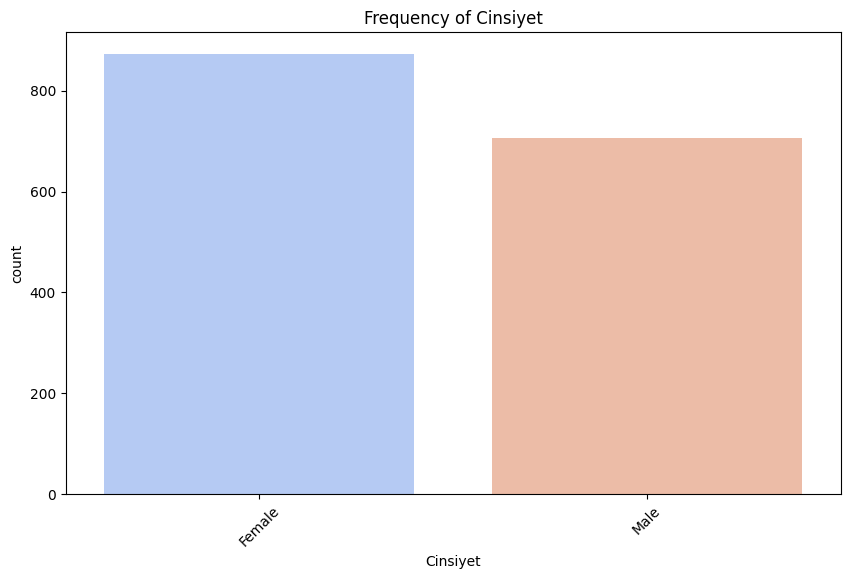


Frequency Distribution of 'Uyruk':
Uyruk
Turkiye    2357
Name: count, dtype: int64


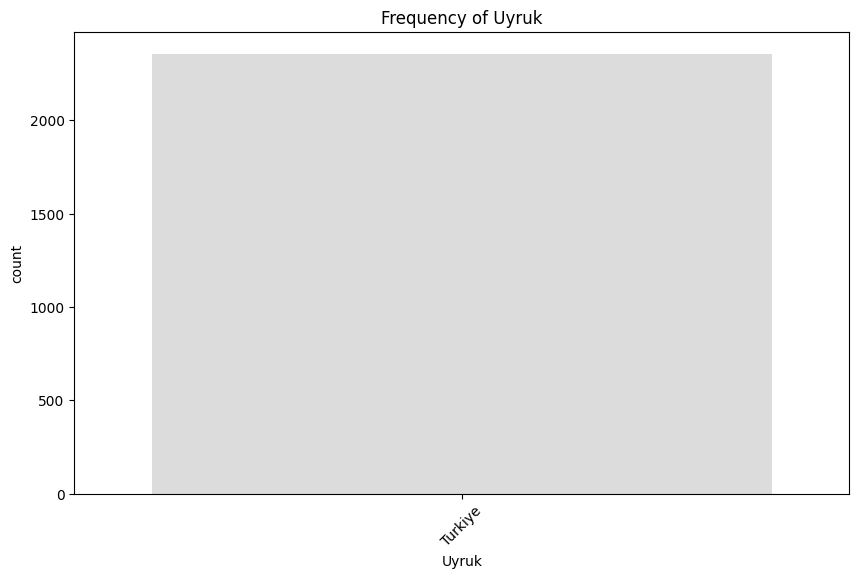


Frequency Distribution of 'Il':
Il
Adana        220
Mersin       207
Trabzon      195
Canakkale    179
Ankara       179
Eskisehir    174
Antalya      171
Bursa        169
Samsun       153
Istanbul     144
Izmir        121
Malatya      109
Kayseri      109
Name: count, dtype: int64


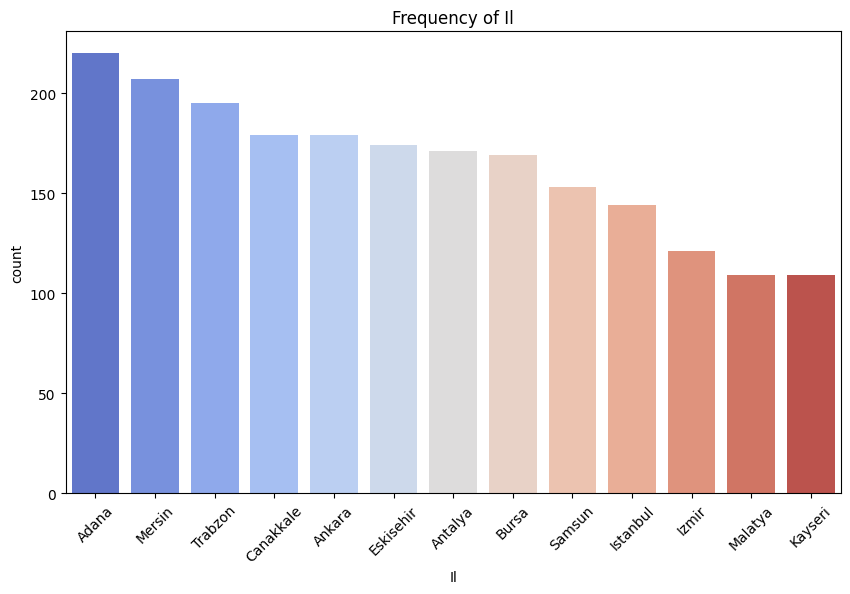


Frequency Distribution of 'Yan_Etki':
Yan_Etki
Agizda Farkli Bir Tat    229
Tansiyon Yukselme        227
Yorgunluk                204
Gormede Bulaniklik       170
Kabizlik                 156
Ishal                    145
Az Uyuma                 141
Terleme                   97
Sinirlilik                81
Gec Bosalma               81
Gucsuzluk                 81
Mide Bulantisi            80
Tansiyon Dusuklugu        74
Carpinti                  72
Istah Artisi              71
Bas Agrisi                71
Karin Agrisi              69
Uykululuk Hali            68
Bulanti                   64
Huzursuzluk               63
Kas Agrisi                58
Deride Morarma            55
Name: count, dtype: int64


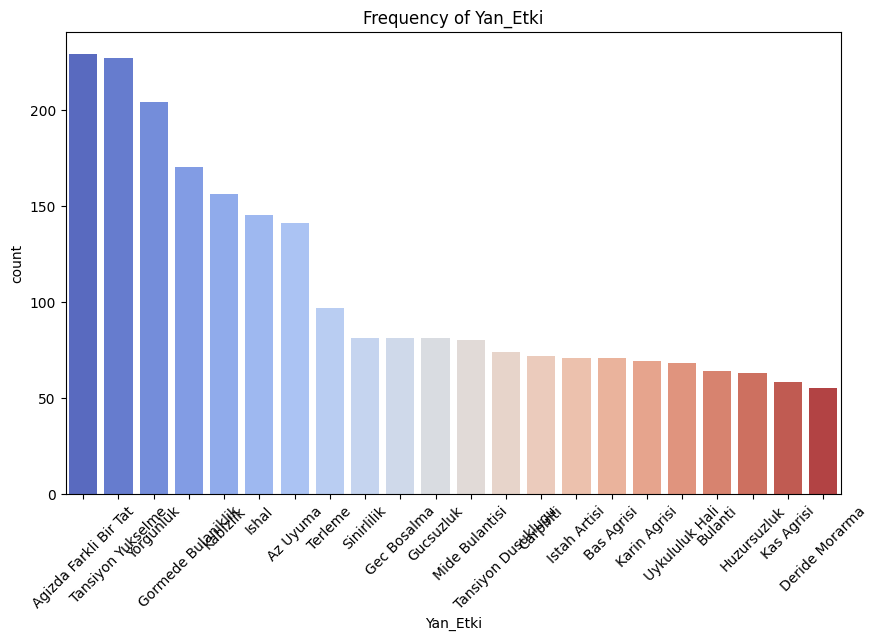


Frequency Distribution of 'Alerjilerim':
Alerjilerim
Domates            118
Karaciger          109
Pancar             100
Balik               98
Havyar              97
Ispanakgiller       95
Kopek               91
Kefir               91
Yogurt              89
Deniz Urunler       87
Muz                 81
Kabak Cekirdegi     77
Kahve               76
Sari Kantaron       75
Toz                 70
Laktoz              60
Bugday              55
Cikolata            53
Elma                53
Ispanak             48
Istiridye           46
Bal                 43
Kedi                38
Lateks              32
Ceviz               30
Sut                 27
Kakao               22
Kolali Icecek       12
Name: count, dtype: int64


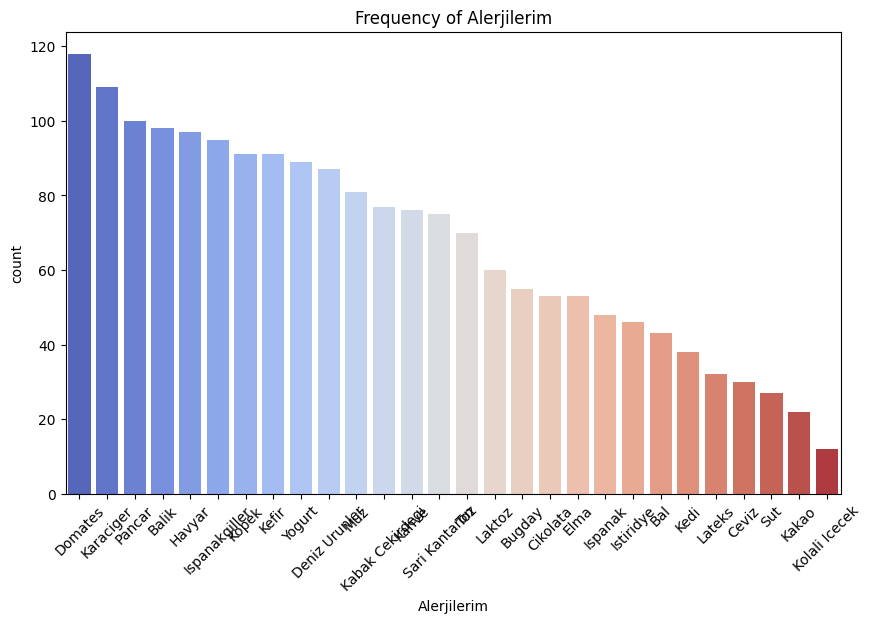


Frequency Distribution of 'Kan Grubu':
Kan Grubu
AB RH-    421
0 RH+     275
B RH+     256
AB RH+    250
B RH-     233
0 RH-     232
A RH+     198
A RH-     145
Name: count, dtype: int64


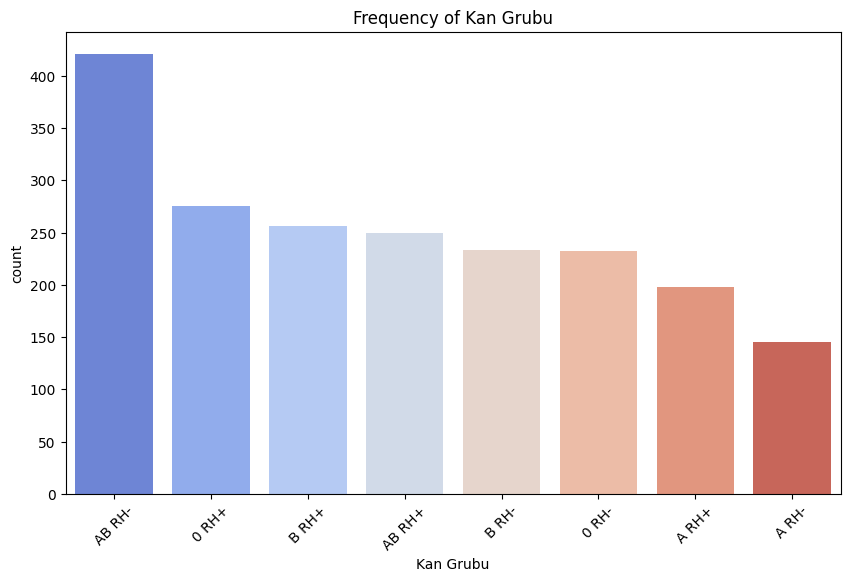


Chi-Square Test and Cramér's V for Categorical Columns:

Between 'Cinsiyet' and 'Uyruk':
  Chi-Square Statistic: 0.0000, P-Value: 1.0000
  Cramér's V: nan

Between 'Cinsiyet' and 'Il':
  Chi-Square Statistic: 84.7498, P-Value: 0.0000
  Cramér's V: 0.2410

Between 'Cinsiyet' and 'Yan_Etki':
  Chi-Square Statistic: 24.9334, P-Value: 0.2501
  Cramér's V: 0.1257

Between 'Cinsiyet' and 'Alerjilerim':
  Chi-Square Statistic: 324.1183, P-Value: 0.0000
  Cramér's V: 0.5204

Between 'Cinsiyet' and 'Kan Grubu':
  Chi-Square Statistic: 103.2313, P-Value: 0.0000
  Cramér's V: 0.2760

Between 'Uyruk' and 'Il':
  Chi-Square Statistic: 0.0000, P-Value: 1.0000
  Cramér's V: nan

Between 'Uyruk' and 'Yan_Etki':
  Chi-Square Statistic: 0.0000, P-Value: 1.0000
  Cramér's V: nan

Between 'Uyruk' and 'Alerjilerim':
  Chi-Square Statistic: 0.0000, P-Value: 1.0000
  Cramér's V: nan

Between 'Uyruk' and 'Kan Grubu':
  Chi-Square Statistic: 0.0000, P-Value: 1.0000
  Cramér's V: nan

Between 'Il' and 'Yan_Etk

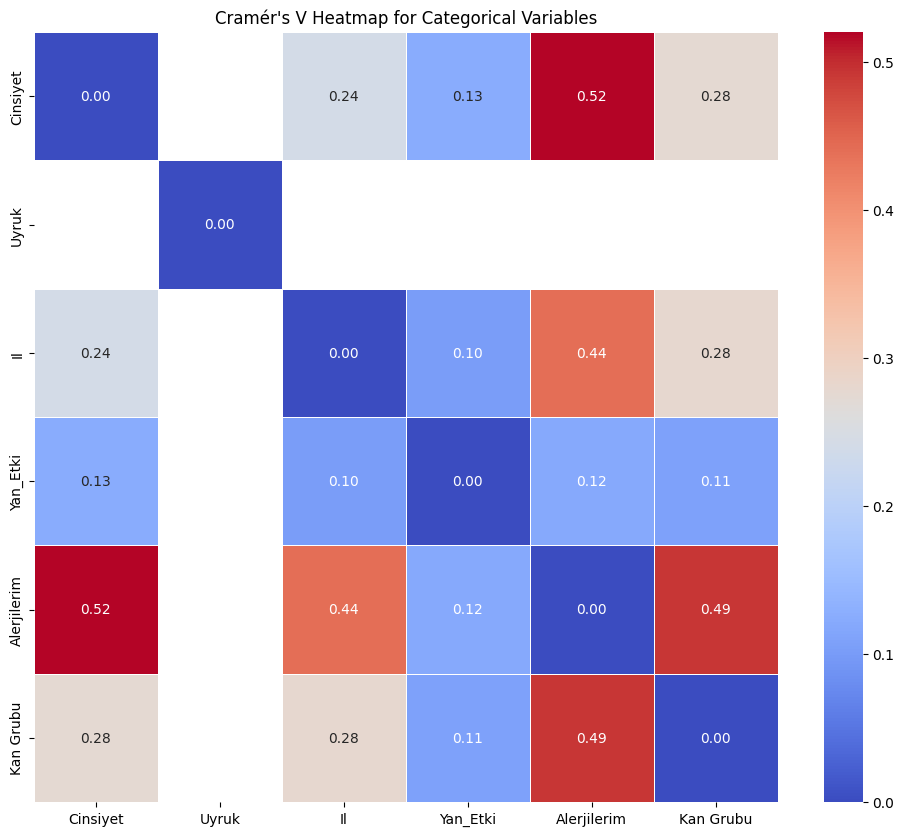

In [14]:


def hype_eda(df, cat_cols):
    """
    Perform advanced exploratory data analysis on specified categorical columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cat_cols (list): List of categorical column names to analyze.
    """
    # Ensure specified columns exist in the DataFrame
    for col in cat_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is not in the DataFrame")

    print(f"Categorical Columns: {cat_cols}")

    # Step 1: Frequency distribution of each categorical column
    for col in cat_cols:
        print(f"\nFrequency Distribution of '{col}':")
        print(df[col].value_counts())

        # Plot frequency distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='coolwarm')
        plt.xticks(rotation=45)
        plt.title(f'Frequency of {col}')
        plt.show()

    # Step 2: Chi-Square test and Cramér's V between all pairs of categorical columns
    print("\nChi-Square Test and Cramér's V for Categorical Columns:")

    for i, col1 in enumerate(cat_cols):
        for col2 in cat_cols[i+1:]:
            # Create contingency table
            contingency_table = pd.crosstab(df[col1], df[col2])

            # Perform Chi-Square test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()  # Total number of observations

            # Calculate Cramér's V
            cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

            # Display results
            print(f"\nBetween '{col1}' and '{col2}':")
            print(f"  Chi-Square Statistic: {chi2:.4f}, P-Value: {p:.4f}")
            print(f"  Cramér's V: {cramers_v:.4f}")

    # Step 3: Visualize Cramér's V matrix (heatmap)
    print("\nCramér's V Heatmap for all categorical columns:")

    # Create Cramér's V matrix
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))),
                                    index=cat_cols, columns=cat_cols)

    for i, col1 in enumerate(cat_cols):
        for j, col2 in enumerate(cat_cols):
            if i != j:
                contingency_table = pd.crosstab(df[col1], df[col2])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                cramers_v_matrix.loc[col1, col2] = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    # Plot the heatmap of Cramér's V values
    plt.figure(figsize=(12, 10))
    sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title("Cramér's V Heatmap for Categorical Variables")
    plt.show()

# Example Usage
# df is the DataFrame you want to analyze
# cat_cols is a list of categorical columns you want to analyze
# cat_cols = ['category1', 'category2', 'category3']
hype_eda(df, cat_cols)


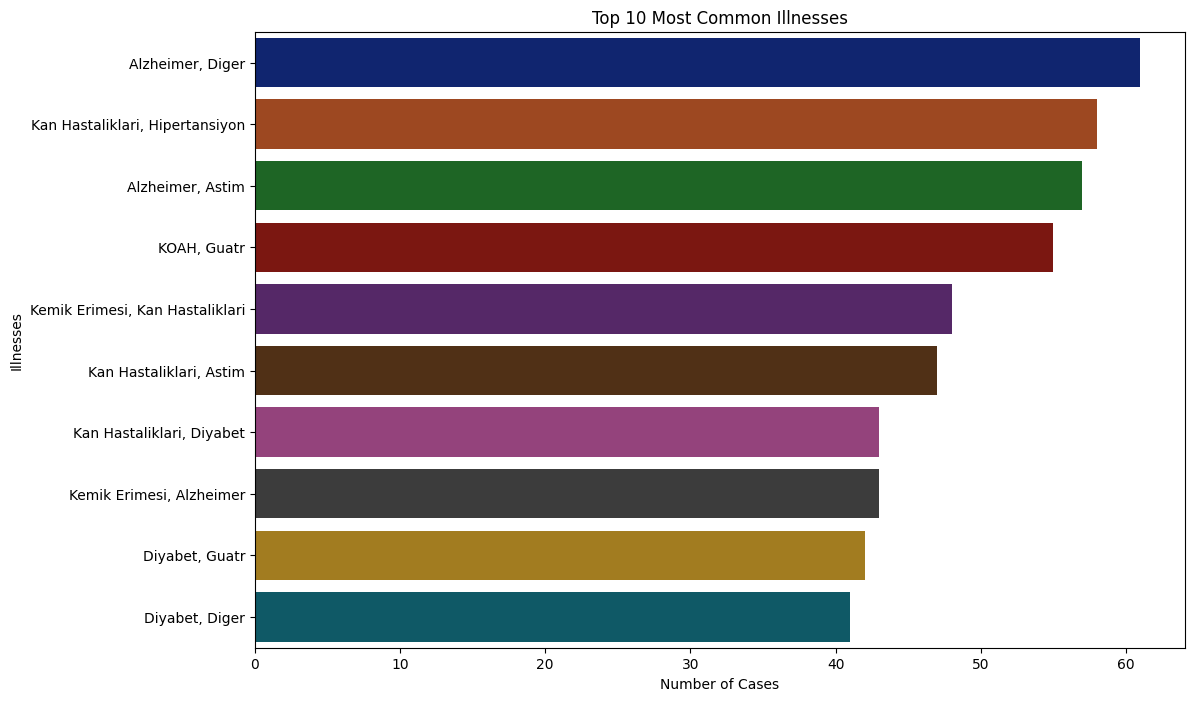

In [15]:
def plot_top_illnesses(df, column_name, top_n=10):
    """
    Plot the top N most common illnesses based on their counts.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    column_name (str): The column name for illnesses
    top_n (int): Number of top illnesses to display

    Returns:
    None
    """
    # Count occurrences of each illness
    illness_counts = df[column_name].value_counts()

    # Get the top N illnesses
    top_illnesses = illness_counts.head(top_n).reset_index()
    top_illnesses.columns = [column_name, 'Count']

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y=column_name, data=top_illnesses, palette="dark")
    plt.title(f'Top {top_n} Most Common Illnesses')
    plt.xlabel('Number of Cases')
    plt.ylabel("Illnesses")
plot_top_illnesses(df, "Kronik Hastaliklarim")

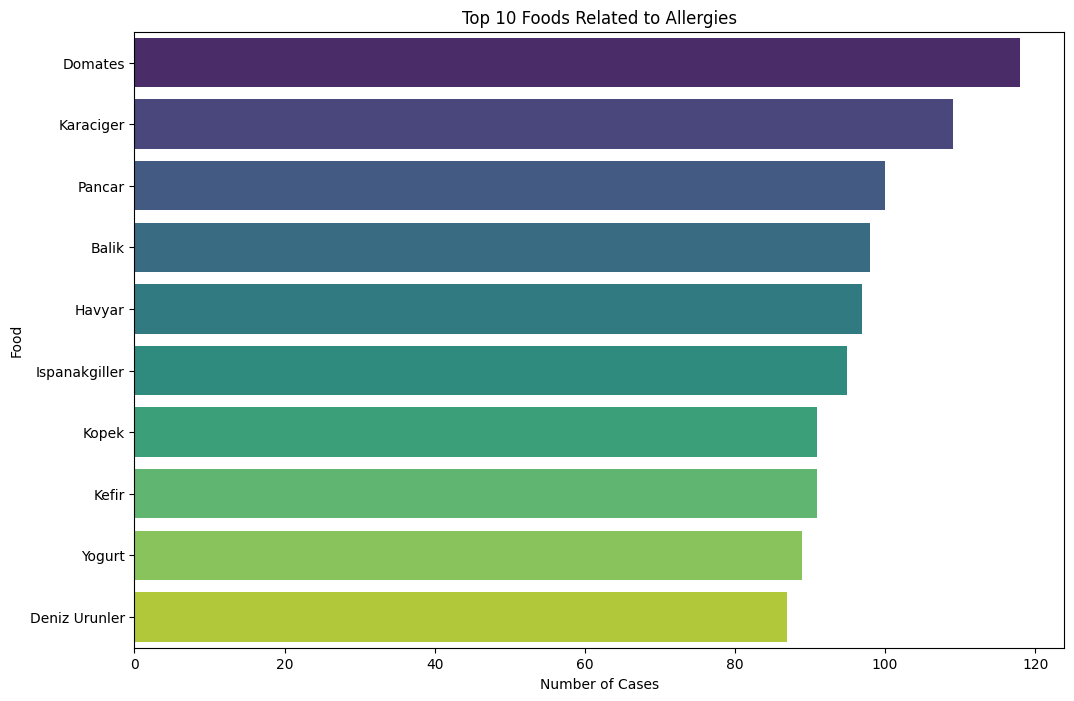

In [16]:
def plot_top_allergy_foods(df, column_name, top_n=10):
    """
    Plot the top N foods related to allergies based on their counts.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    column_name (str): The column name for allergy-related foods
    top_n (int): Number of top allergy-related foods to display

    Returns:
    None
    """
    # Count occurrences of each food
    food_counts = df[column_name].value_counts()

    # Get the top N foods
    top_foods = food_counts.head(top_n).reset_index()
    top_foods.columns = [column_name, 'Count']

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y=column_name, data=top_foods, palette="viridis")
    plt.title(f'Top {top_n} Foods Related to Allergies')
    plt.xlabel('Number of Cases')
    plt.ylabel('Food')
    plt.show()

# Example usage:
# df = pd.read_csv('your_data.csv')
plot_top_allergy_foods(df, 'Alerjilerim')


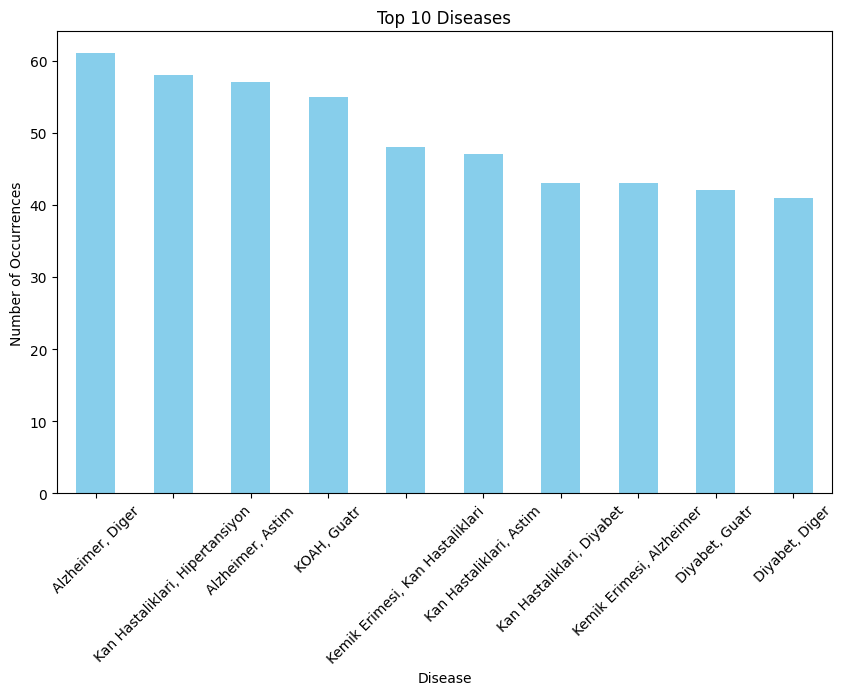

In [17]:
top_10_diseases = df['Kronik Hastaliklarim'].value_counts().head(10)
# Plot the top 10 diseases
top_10_diseases.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Top 10 Diseases')
plt.xlabel('Disease')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

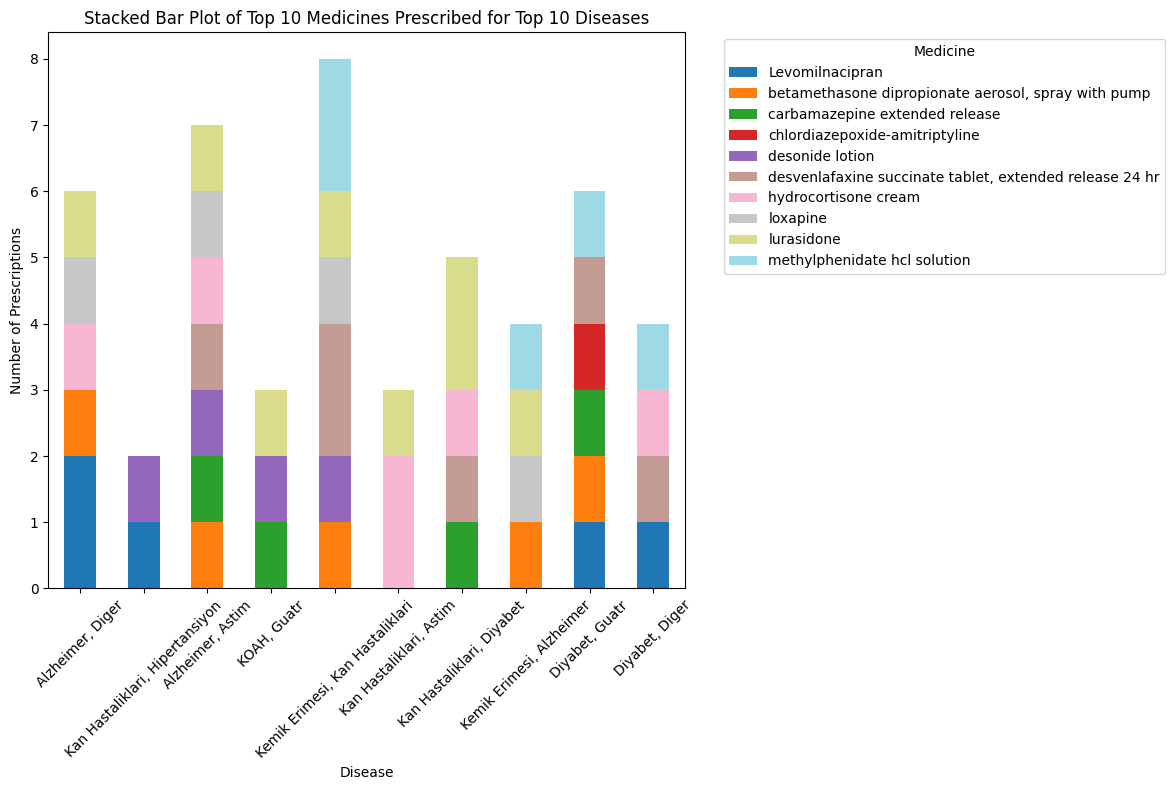

In [18]:
top_10_diseases = df['Kronik Hastaliklarim'].value_counts().head(10).index
top_10_medicines = df['Ilac_Adi'].value_counts().head(10).index
filtered_df = df[df['Kronik Hastaliklarim'].isin(top_10_diseases) & df['Ilac_Adi'].isin(top_10_medicines)]
# Create a pivot table for visualization
pivot_table = filtered_df.pivot_table(index='Kronik Hastaliklarim', columns='Ilac_Adi', aggfunc='size', fill_value=0)
pivot_table = pivot_table.loc[top_10_diseases]  # Ensure order of diseases

# Plotting the stacked bar plot
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Stacked Bar Plot of Top 10 Medicines Prescribed for Top 10 Diseases')
plt.xlabel('Disease')
plt.ylabel('Number of Prescriptions')
plt.legend(title='Medicine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

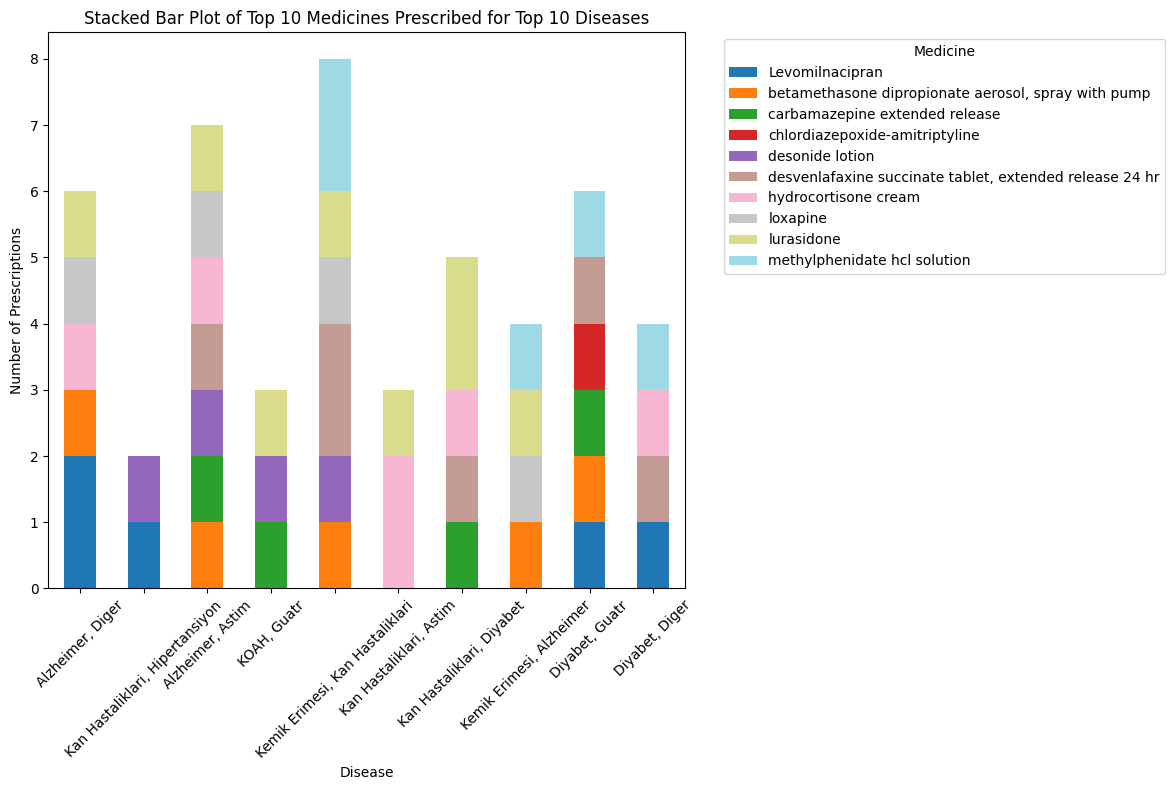

In [19]:
top_10_diseases = df['Kronik Hastaliklarim'].value_counts().head(10).index
top_10_medicines = df['Ilac_Adi'].value_counts().head(10).index
filtered_df = df[df['Kronik Hastaliklarim'].isin(top_10_diseases) & df['Ilac_Adi'].isin(top_10_medicines)]
# Create a pivot table for visualization
pivot_table = filtered_df.pivot_table(index='Kronik Hastaliklarim', columns='Ilac_Adi', aggfunc='size', fill_value=0)
pivot_table = pivot_table.loc[top_10_diseases]  # Ensure order of diseases

# Plotting the stacked bar plot
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Stacked Bar Plot of Top 10 Medicines Prescribed for Top 10 Diseases')
plt.xlabel('Disease')
plt.ylabel('Number of Prescriptions')
plt.legend(title='Medicine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
disease_medicine_counts = df.groupby(['Kronik Hastaliklarim', 'Ilac_Adi']).size().reset_index(name='count')

# Find top medicines for each disease
top_medicines_per_disease = (disease_medicine_counts
                             .sort_values(by=['Kronik Hastaliklarim', 'count'], ascending=[True, False])
                             .groupby('Kronik Hastaliklarim')
                             .head(10))


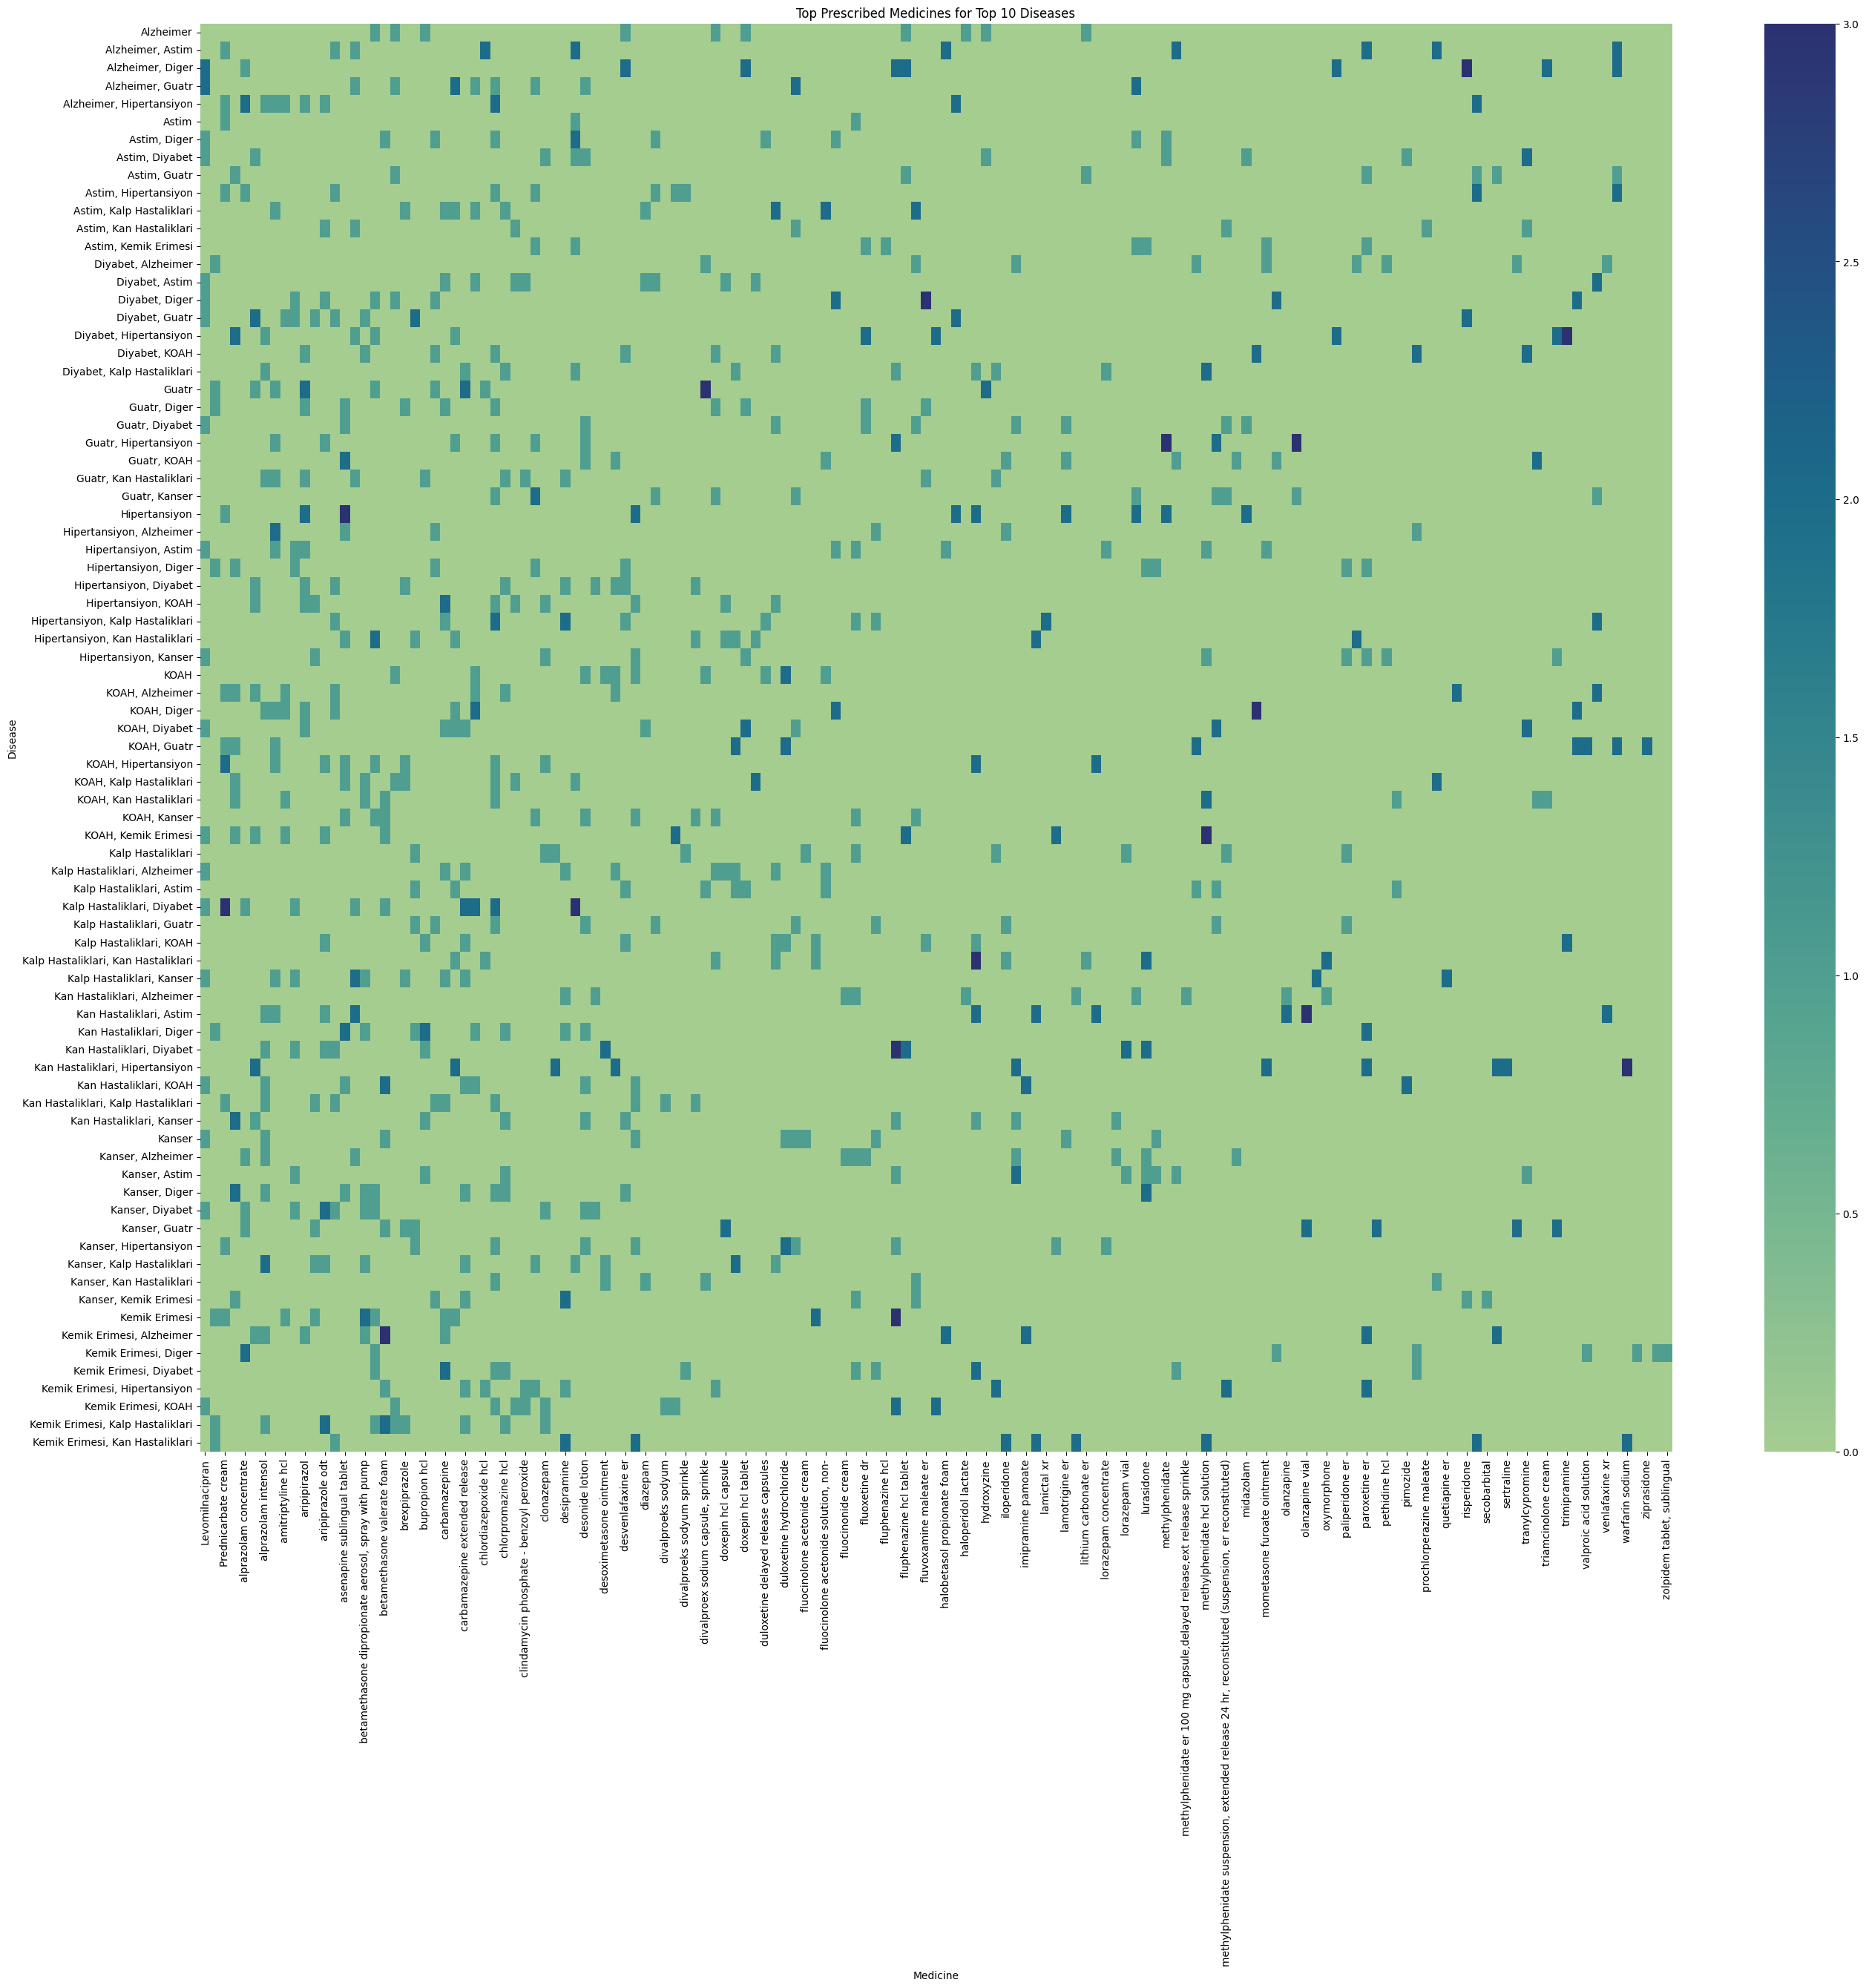

In [21]:
# Pivot table to see medicines prescribed for top 10 diseases
pivot_table = top_medicines_per_disease.pivot_table(index='Kronik Hastaliklarim', columns='Ilac_Adi', values='count', fill_value=0)

# Plotting heatmap
plt.figure(figsize=(32,25))
sns.heatmap(pivot_table, cmap='crest')
plt.title('Top Prescribed Medicines for Top 10 Diseases')
plt.xlabel('Medicine')
plt.ylabel('Disease')
plt.show()

In [22]:
def create_contingency_table(df, col1, col2):
    """
    Create a contingency table for two categorical columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    col1 (str): The first categorical column
    col2 (str): The second categorical column

    Returns:
    pd.DataFrame: Contingency table
    """
    contingency_table = pd.crosstab(df[col1], df[col2])
    return contingency_table

# Example usage:
# df = pd.read_csv('your_data.csv')
contingency_table = create_contingency_table(df, 'Kronik Hastaliklarim', 'Alerjilerim')
print(contingency_table)


Alerjilerim                       Bal  Balik  Bugday  Ceviz  Cikolata  \
Kronik Hastaliklarim                                                    
Alzheimer                           0      0       0      0         0   
Alzheimer, Astim                    0      0       0      0         0   
Alzheimer, Diger                    0      0       0      0         0   
Alzheimer, Guatr                    0      0       0      0         0   
Alzheimer, Hipertansiyon            0      0       0      0         0   
...                               ...    ...     ...    ...       ...   
Kemik Erimesi, Diyabet              0      0       0      0         0   
Kemik Erimesi, Hipertansiyon        0      0       0      0         0   
Kemik Erimesi, KOAH                 0      0       0      0         0   
Kemik Erimesi, Kalp Hastaliklari    0      0       0      0         0   
Kemik Erimesi, Kan Hastaliklari     0      0       0      0         0   

Alerjilerim                       Deniz Urunler  D

In [23]:
def perform_chi2_test(contingency_table):
    """
    Perform the Chi-Square test for independence.

    Parameters:
    contingency_table (pd.DataFrame): Contingency table of the two categorical variables

    Returns:
    None
    """
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print("There is a significant association between the two variables (Reject H0).")
    else:
        print("There is no significant association between the two variables (Fail to reject H0).")

# Example usage:
perform_chi2_test(contingency_table)


Chi-Square Statistic: 25368.965439329826
p-value: 0.0
There is a significant association between the two variables (Reject H0).


In [24]:
def calculate_cramers_v(contingency_table):
    """
    Calculate Cramér's V statistic.

    Parameters:
    contingency_table (pd.DataFrame): Contingency table of the two categorical variables

    Returns:
    float: Cramér's V statistic
    """
    chi2_stat, _, _, _ = stats.chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2_stat / (n * k))
    return cramers_v

# Example usage:
cramers_v = calculate_cramers_v(contingency_table)
print(f"Cramér's V: {cramers_v}")


Cramér's V: 0.7731134440091846


In [25]:
df['Cinsiyet'] = df['Cinsiyet'].replace({'Male': 'Erkek', 'Female': 'Kadin'})

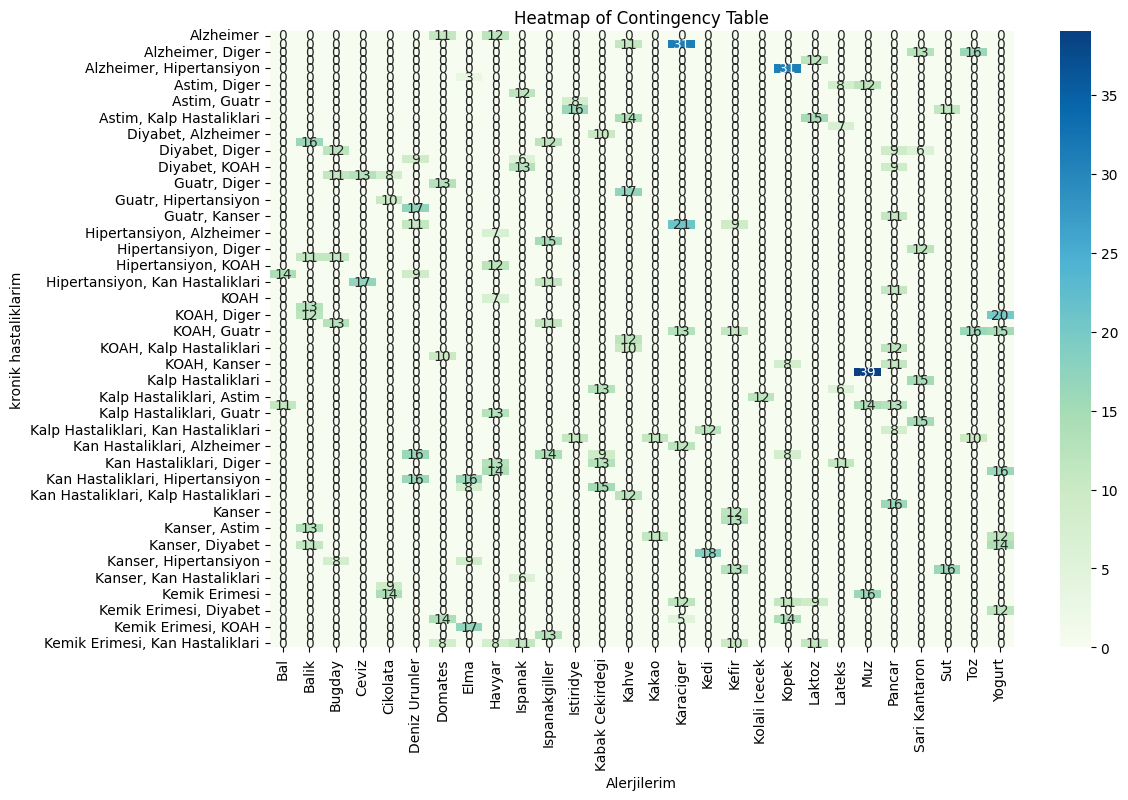

In [26]:
def plot_contingency_table(contingency_table):
    """
    Plot a heatmap of the contingency table.

    Parameters:
    contingency_table (pd.DataFrame): Contingency table of the two categorical variables

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='GnBu')
    plt.title('Heatmap of Contingency Table')
    plt.xlabel('Alerjilerim')
    plt.ylabel('kronik hastaliklarim')
    plt.show()

# Example usage:
plot_contingency_table(contingency_table)


In [27]:
# Chi-Square Test calculation
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V calculation
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
print("Cramér's V:", cramers_v)


# Interpretation of the results
alpha = 0.05
if p < alpha:
    print("Result: There is a significant relationship between the two variables.")
else:
    print("Result: There is no significant relationship between the two variables.")

print("Cramér's V Value:", cramers_v)
if cramers_v < 0.1:
    print("Relationship: Very weak")
elif cramers_v < 0.3:
    print("Relationship: Weak")
elif cramers_v < 0.5:
    print("Relationship: Moderate")
else:
    print("Relationship: Strong")


Chi-Square Statistic: 25368.965439329826
p-value: 0.0
Degrees of Freedom: 1998
Expected Frequencies:
Alerjilerim                            Bal     Balik    Bugday     Ceviz  \
Kronik Hastaliklarim                                                       
Alzheimer                         0.365776  1.111959  0.804707  0.438931   
Alzheimer, Astim                  0.667939  2.030534  1.469466  0.801527   
Alzheimer, Diger                  0.461196  1.402036  1.014631  0.553435   
Alzheimer, Guatr                  0.190840  0.580153  0.419847  0.229008   
Alzheimer, Hipertansiyon          0.493003  1.498728  1.084606  0.591603   
...                                    ...       ...       ...       ...   
Kemik Erimesi, Diyabet            0.190840  0.580153  0.419847  0.229008   
Kemik Erimesi, Hipertansiyon      0.524809  1.595420  1.154580  0.629771   
Kemik Erimesi, KOAH               0.270356  0.821883  0.594784  0.324427   
Kemik Erimesi, Kalp Hastaliklari  0.206743  0.628499  0.454835 

Yan_Etki
Agizda Farkli Bir Tat    229
Tansiyon Yukselme        227
Yorgunluk                204
Gormede Bulaniklik       170
Kabizlik                 156
Ishal                    145
Az Uyuma                 141
Terleme                   97
Sinirlilik                81
Gec Bosalma               81
Gucsuzluk                 81
Mide Bulantisi            80
Tansiyon Dusuklugu        74
Carpinti                  72
Istah Artisi              71
Bas Agrisi                71
Karin Agrisi              69
Uykululuk Hali            68
Bulanti                   64
Huzursuzluk               63
Kas Agrisi                58
Deride Morarma            55
Name: count, dtype: int64


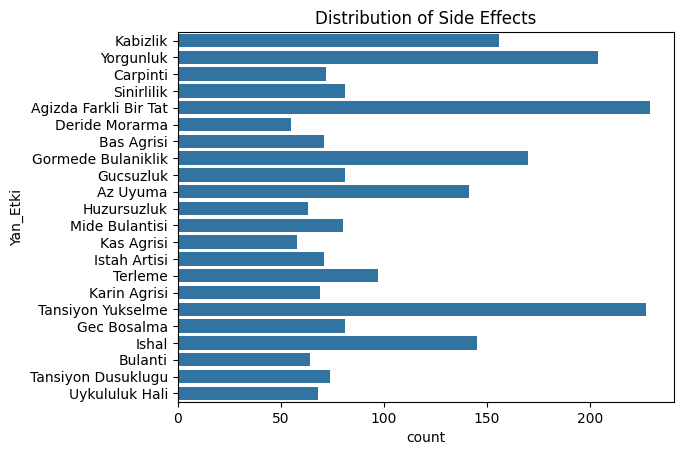

In [28]:
# Analyze side effects
side_effects_distribution = df['Yan_Etki'].value_counts()

print(side_effects_distribution)

# Visualize side effects
sns.countplot(y='Yan_Etki', data=df)
plt.title('Distribution of Side Effects')
plt.show()

Yan_Etki                          Agizda Farkli Bir Tat  Az Uyuma  Bas Agrisi  \
Kronik Hastaliklarim                                                            
Alzheimer                                             1         1           1   
Alzheimer, Astim                                      3         7           1   
Alzheimer, Diger                                     12         3           0   
Alzheimer, Guatr                                      4         0           0   
Alzheimer, Hipertansiyon                              3         1           1   
...                                                 ...       ...         ...   
Kemik Erimesi, Diyabet                                0         2           0   
Kemik Erimesi, Hipertansiyon                          3         3           0   
Kemik Erimesi, KOAH                                   1         2           0   
Kemik Erimesi, Kalp Hastaliklari                      2         0           0   
Kemik Erimesi, Kan Hastalikl

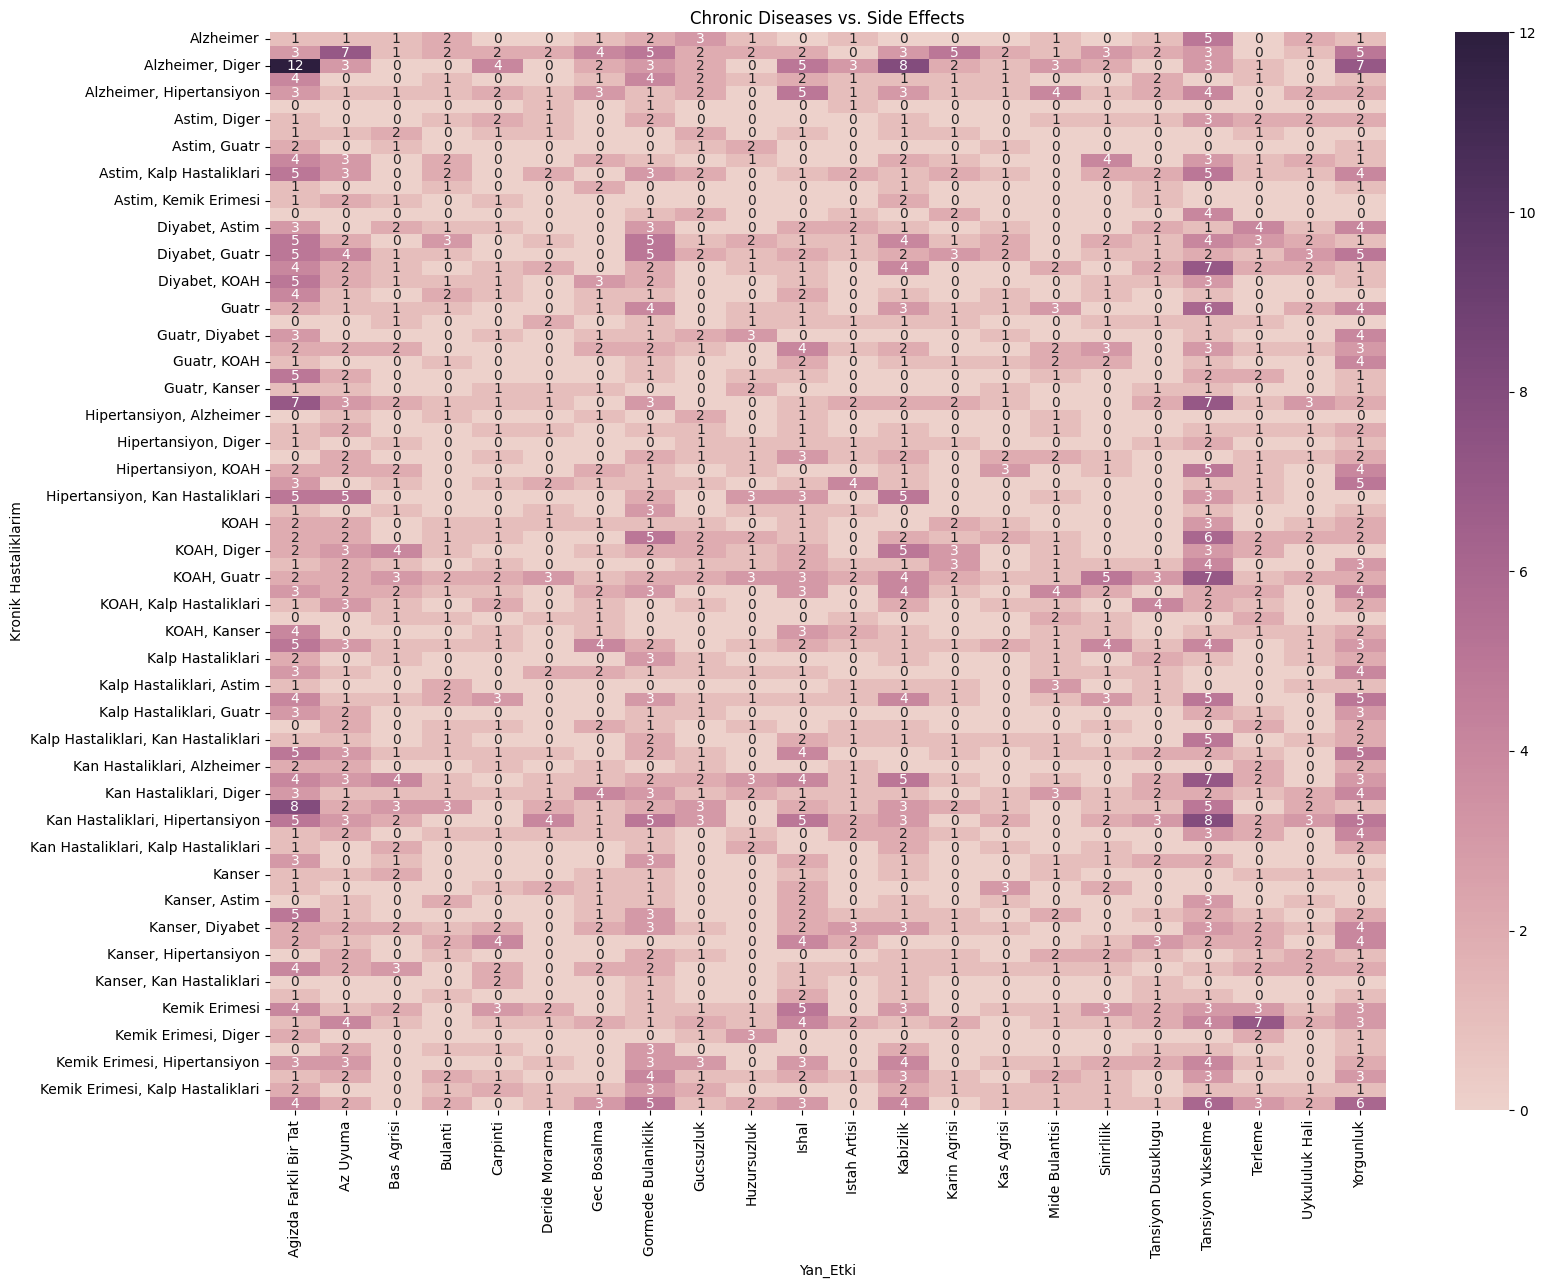

In [29]:
# Cross-tabulate chronic diseases and side effects
chronic_side_effects = pd.crosstab(df['Kronik Hastaliklarim'], df['Yan_Etki'])
print(chronic_side_effects)

# Visualize cross-tabulation
plt.figure(figsize=(18, 14))
sns.heatmap(chronic_side_effects, annot=True,cmap = sns.cubehelix_palette(as_cmap=True))
plt.title('Chronic Diseases vs. Side Effects')
plt.show()

In [30]:
medicine_side_effect_counts = df.groupby(['Ilac_Adi', 'Yan_Etki']).size().reset_index(name='Occurences')

# Sort by count to get the most frequent side effects for each medicine
medicine_side_effect_counts = medicine_side_effect_counts.sort_values(by='Occurences', ascending=False)

# View the results
print(medicine_side_effect_counts.head(10))

                              Ilac_Adi               Yan_Etki  Occurences
1006                        lurasidone      Tansiyon Yukselme           6
1369                       risperidone                  Ishal           6
986                           loxapine               Kabizlik           5
160        asenapine sublingual tablet      Tansiyon Yukselme           5
1251                     paroxetine er               Az Uyuma           5
196   betamethasone dipropionate cream         Mide Bulantisi           5
1535                        vilazodone  Agizda Farkli Bir Tat           5
1599       zolpidem tablet, sublingual  Agizda Farkli Bir Tat           5
401                        desipramine              Yorgunluk           5
254                      carbamazepine               Az Uyuma           5


In [31]:
# Identify the most frequent side effect for each medicine
most_common_side_effects = medicine_side_effect_counts.groupby('Ilac_Adi').first().reset_index()

# View the results
print(most_common_side_effects.head(10))  # Show top 10 medicines with their most common side effects

                 Ilac_Adi               Yan_Etki  Occurences
0         Levomilnacipran  Agizda Farkli Bir Tat           4
1      Mometasone furoate      Tansiyon Yukselme           2
2     Prednicarbate cream                  Ishal           2
3              alprazolam                Terleme           4
4  alprazolam concentrate     Gormede Bulaniklik           2
5           alprazolam er            Gec Bosalma           2
6     alprazolam intensol              Yorgunluk           3
7          alprazolam odt     Gormede Bulaniklik           3
8       amitriptyline hcl              Yorgunluk           3
9               amoksapin      Tansiyon Yukselme           2


count    2357.000000
mean       62.234620
std         6.576611
min        47.000000
25%        58.000000
50%        62.000000
75%        67.000000
max        77.000000
Name: Sure, dtype: float64


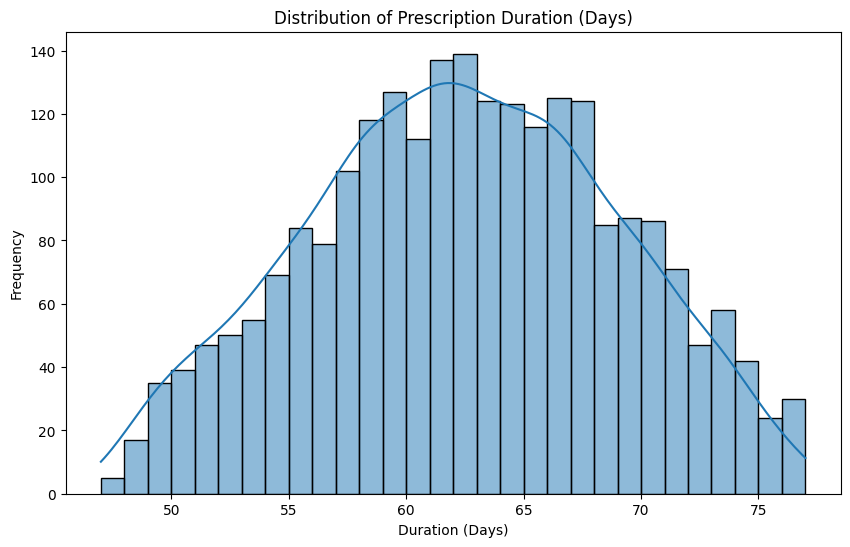

In [32]:
df['Sure'] = (df['Ilac_Bitis_Tarihi'] - df['Ilac_Baslangic_Tarihi']).dt.days
print(df['Sure'].describe())


# Distribution plot of prescription duration
plt.figure(figsize=(10, 6))
sns.histplot(df['Sure'], kde=True, bins=30)
plt.title('Distribution of Prescription Duration (Days)')
plt.xlabel('Duration (Days)')
plt.ylabel('Frequency')
plt.show()

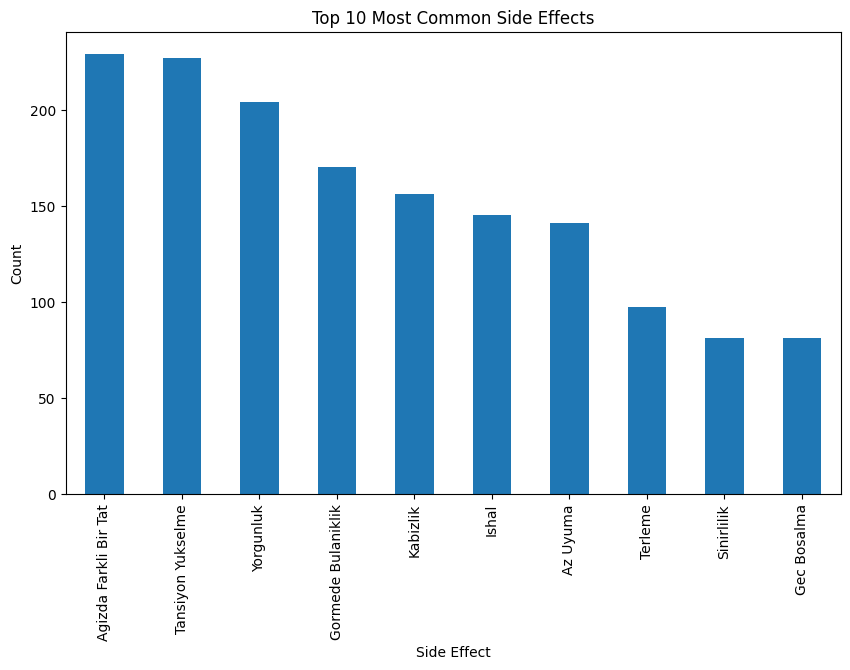

In [33]:
# Count the occurrences of each side effect
side_effect_counts = df['Yan_Etki'].value_counts()

# Plot the top 10 side effects
plt.figure(figsize=(10, 6))
side_effect_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Common Side Effects')
plt.xlabel('Side Effect')
plt.ylabel('Count')
plt.show()


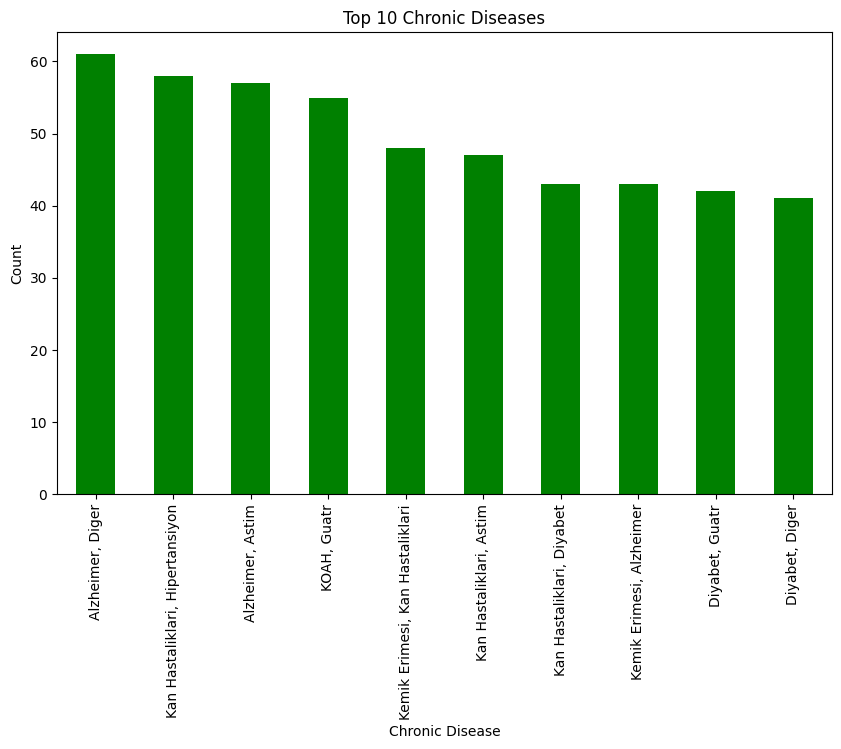

In [34]:
# Count and plot the most frequent chronic diseases
chronic_disease_counts = df['Kronik Hastaliklarim'].value_counts()

plt.figure(figsize=(10, 6))
chronic_disease_counts.head(10).plot(kind='bar', color = "#008000")
plt.title('Top 10 Chronic Diseases')
plt.xlabel('Chronic Disease')
plt.ylabel('Count')
plt.show()

Kronik Hastaliklarim  Alzheimer  Alzheimer, Astim  Alzheimer, Diger  \
Kan Grubu                                                             
0 RH+                        11                 0                 0   
0 RH-                         0                 0                 0   
A RH+                         0                 0                 0   
A RH-                         0                 0                 0   
AB RH+                        0                 0                10   
AB RH-                        0                31                11   
B RH+                        12                26                 0   
B RH-                         0                 0                 0   

Kronik Hastaliklarim  Alzheimer, Guatr  Alzheimer, Hipertansiyon  Astim  \
Kan Grubu                                                                 
0 RH+                                0                        10      0   
0 RH-                                0                         0

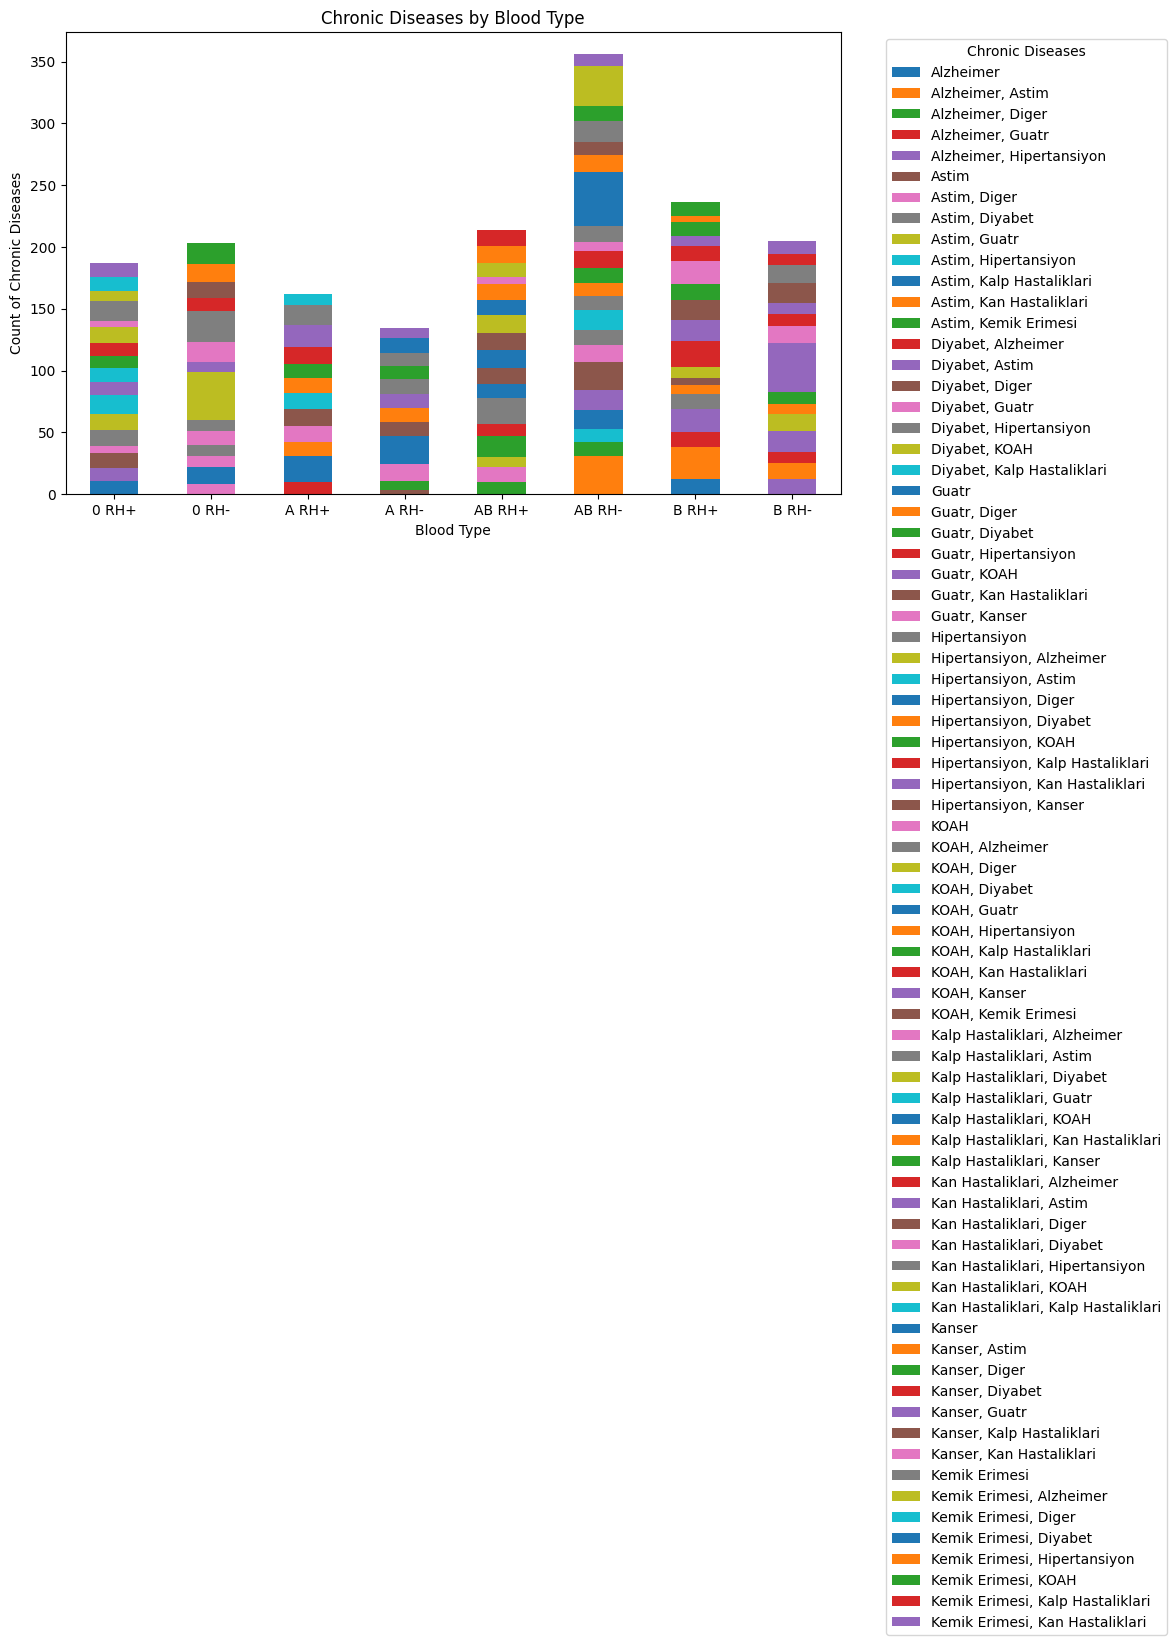

In [35]:
blood_chronic_ct = pd.crosstab(df['Kan Grubu'], df['Kronik Hastaliklarim'])
print(blood_chronic_ct)
blood_chronic_ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Chronic Diseases by Blood Type')
plt.xlabel('Blood Type')
plt.ylabel('Count of Chronic Diseases')
plt.xticks(rotation=0)
plt.legend(title='Chronic Diseases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

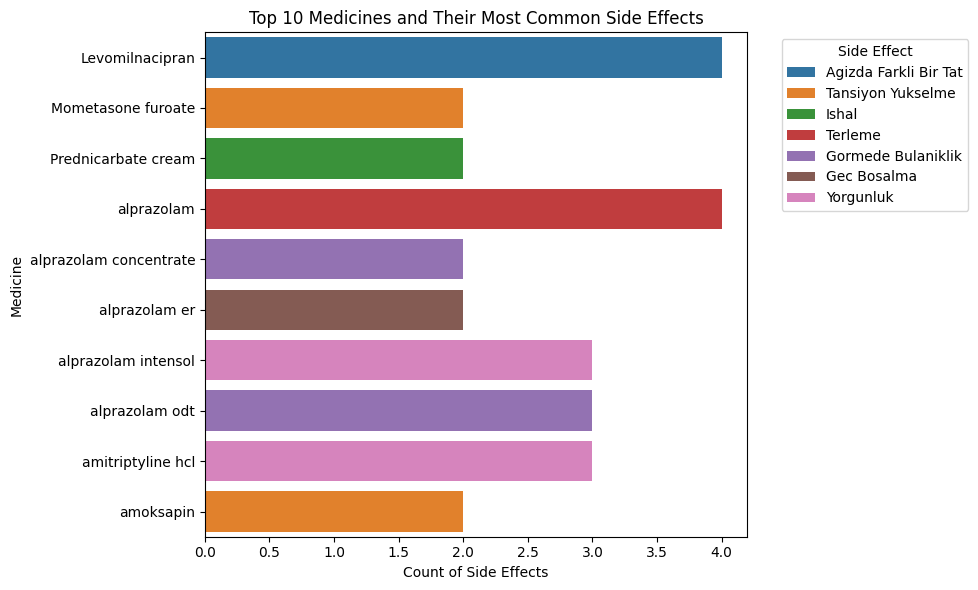

In [36]:
# Plot the top 10 medicines and their most common side effects
plt.figure(figsize=(10, 6))
sns.barplot(x='Occurences', y='Ilac_Adi', hue='Yan_Etki', data=most_common_side_effects.head(10))
plt.title('Top 10 Medicines and Their Most Common Side Effects')
plt.xlabel('Count of Side Effects')
plt.ylabel('Medicine')
plt.legend(title='Side Effect', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

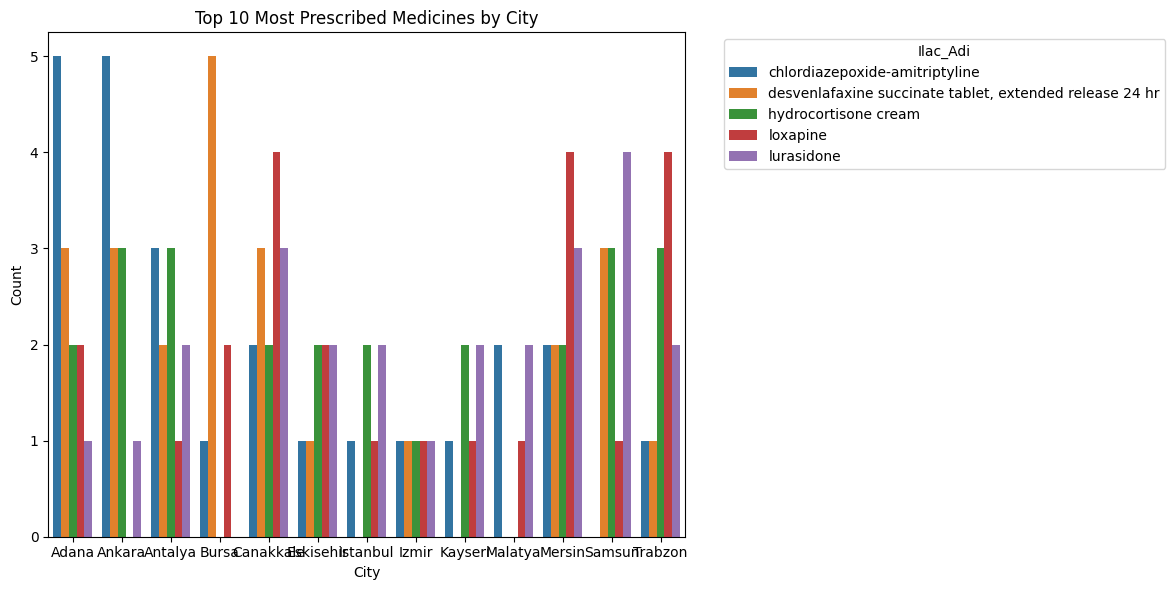

In [37]:
# Step 1: Find the top 10 most prescribed medicines
top_5_ilac = df['Ilac_Adi'].value_counts().nlargest(5).index

# Step 2: Filter the data to include only the top 10 medicines
filtered_data = df[df['Ilac_Adi'].isin(top_5_ilac)]

# Step 3: Group by 'City' and 'Ilac_Adi' and count occurrences
city_ilac_count = filtered_data.groupby(["Il", 'Ilac_Adi']).size().reset_index(name='Count')

# Step 4: Visualize the data using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Il', y='Count', hue='Ilac_Adi', data=city_ilac_count)

# Add a title and labels
plt.title('Top 10 Most Prescribed Medicines by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.legend(title='Ilac_Adi', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [38]:
# Chi-Square Test calculation
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V calculation
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("Chi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))
print("Cramér's V:", cramers_v)


# Interpretation of the results
alpha = 0.05
if p < alpha:
    print("Result: There is a significant relationship between the two variables.")
else:
    print("Result: There is no significant relationship between the two variables.")

print("Cramér's V Value:", cramers_v)
if cramers_v < 0.1:
    print("Relationship: Very weak")
elif cramers_v < 0.3:
    print("Relationship: Weak")
elif cramers_v < 0.5:
    print("Relationship: Moderate")
else:
    print("Relationship: Strong")


Chi-Square Statistic: 25368.965439329826
p-value: 0.0
Degrees of Freedom: 1998
Expected Frequencies:
Alerjilerim                            Bal     Balik    Bugday     Ceviz  \
Kronik Hastaliklarim                                                       
Alzheimer                         0.365776  1.111959  0.804707  0.438931   
Alzheimer, Astim                  0.667939  2.030534  1.469466  0.801527   
Alzheimer, Diger                  0.461196  1.402036  1.014631  0.553435   
Alzheimer, Guatr                  0.190840  0.580153  0.419847  0.229008   
Alzheimer, Hipertansiyon          0.493003  1.498728  1.084606  0.591603   
...                                    ...       ...       ...       ...   
Kemik Erimesi, Diyabet            0.190840  0.580153  0.419847  0.229008   
Kemik Erimesi, Hipertansiyon      0.524809  1.595420  1.154580  0.629771   
Kemik Erimesi, KOAH               0.270356  0.821883  0.594784  0.324427   
Kemik Erimesi, Kalp Hastaliklari  0.206743  0.628499  0.454835 

In [39]:
medicine_side_effect_counts = df.groupby(['Ilac_Adi', 'Yan_Etki']).size().reset_index(name='Occurences')

# Sort by count to get the most frequent side effects for each medicine
medicine_side_effect_counts = medicine_side_effect_counts.sort_values(by='Occurences', ascending=False)

# View the results
print(medicine_side_effect_counts.head(10))

                              Ilac_Adi               Yan_Etki  Occurences
1006                        lurasidone      Tansiyon Yukselme           6
1369                       risperidone                  Ishal           6
986                           loxapine               Kabizlik           5
160        asenapine sublingual tablet      Tansiyon Yukselme           5
1251                     paroxetine er               Az Uyuma           5
196   betamethasone dipropionate cream         Mide Bulantisi           5
1535                        vilazodone  Agizda Farkli Bir Tat           5
1599       zolpidem tablet, sublingual  Agizda Farkli Bir Tat           5
401                        desipramine              Yorgunluk           5
254                      carbamazepine               Az Uyuma           5


In [40]:
# Identify the most frequent side effect for each medicine
most_common_side_effects = medicine_side_effect_counts.groupby('Ilac_Adi').first().reset_index()

# View the results
print(most_common_side_effects.head(10))  # Show top 10 medicines with their most common side effects

                 Ilac_Adi               Yan_Etki  Occurences
0         Levomilnacipran  Agizda Farkli Bir Tat           4
1      Mometasone furoate      Tansiyon Yukselme           2
2     Prednicarbate cream                  Ishal           2
3              alprazolam                Terleme           4
4  alprazolam concentrate     Gormede Bulaniklik           2
5           alprazolam er            Gec Bosalma           2
6     alprazolam intensol              Yorgunluk           3
7          alprazolam odt     Gormede Bulaniklik           3
8       amitriptyline hcl              Yorgunluk           3
9               amoksapin      Tansiyon Yukselme           2


In [41]:
def convert_boolean_to_integer(df):
    # Loop through each column
    for column in df.columns:
        # Check if the column is of boolean type
        if df[column].dtype == 'bool':
            # Convert boolean column to integer
            df[column] = df[column].astype(int)
    return df
convert_boolean_to_integer(df)

Kullanici_id Cinsiyet Dogum_Tarihi    Uyruk         Il  \
0              107    Erkek   1960-03-01  Turkiye  Canakkale   
1              140    Erkek   1939-10-12  Turkiye    Trabzon   
2                2    Kadin   1976-12-17  Turkiye  Canakkale   
3               83    Erkek   1977-06-17  Turkiye      Adana   
4                7    Kadin   1976-09-03  Turkiye      Izmir   
...            ...      ...          ...      ...        ...   
2352             9      NaN   1957-01-04  Turkiye        NaN   
2353           101    Kadin   2004-11-09  Turkiye     Mersin   
2354           127    Kadin   1951-11-29  Turkiye     Mersin   
2355           178    Erkek   1980-01-30  Turkiye    Kayseri   
2356           174    Kadin   1986-11-07  Turkiye   Istanbul   

                               Ilac_Adi Ilac_Baslangic_Tarihi  \
0                       trifluoperazine            2022-01-09   
1                      fluphenazine hcl            2022-01-09   
2                       warfarin sodium            2022-01-11   
3                         valproic acid            2022-01-04   
4        carbamazepine extended release            2022-01-13   
...                                 ...                   ...   
2352  desoximetasone spray, non-aerosol            2022-01-13   
2353              olanzapine-fluoxetine            2022-01-02   
2354                          trazodone            2022-01-02   
2355           duloxetine hydrochloride            2022-01-02   
2356                      valproic acid            2022-01-06   

     Ilac_Bitis_Tarihi               Yan_Etki Yan_Etki_Bildirim_Tarihi  \
0           2022-03-04               Kabizlik      2022-02-19 18:28:43   
1           2022-03-08              Yorgunluk      2022-02-03 20:48:17   
2           2022-03-12               Carpinti      2022-02-04 05:29:20   
3           2022-03-12             Sinirlilik      2022-02-08 01:01:21   
4           2022-03-06  Agizda Farkli Bir Tat      2022-02-12 05:33:06   
...                ...                    ...                      ...   
2352        2022-03-04                  Ishal      2022-02-12 19:13:43   
2353        2022-03-05  Agizda Farkli Bir Tat      2022-02-19 17:39:48   
2354        2022-03-12              Yorgunluk      2022-02-03 20:48:17   
2355        2022-03-08               Carpinti      2022-02-04 05:29:20   
2356        2022-03-06           Istah Artisi      2022-02-17 07:08:01   

        Alerjilerim             Kronik Hastaliklarim  \
0             Ceviz  Hipertansiyon, Kan Hastaliklari   
1               Toz                              NaN   
2               Muz       Kalp Hastaliklari, Diyabet   
3            Pancar                   Diyabet, Diger   
4               NaN       Diyabet, Kalp Hastaliklari   
...             ...                              ...   
2352  Ispanakgiller                              NaN   
2353      Istiridye                              NaN   
2354  Deniz Urunler                      Guatr, KOAH   
2355  Sari Kantaron                 Alzheimer, Diger   
2356            NaN                 Alzheimer, Diger   

      Baba Kronik Hastaliklari          Anne Kronik Hastaliklari  \
0         Guatr, Hipertansiyon                              KOAH   
1                 Guatr, Diger  Hipertansiyon, Kalp Hastaliklari   
2                Diyabet, KOAH            Kemik Erimesi, Diyabet   
3     Kalp Hastaliklari, Diger                               NaN   
4     Alzheimer, Hipertansiyon   Kan Hastaliklari, Kemik Erimesi   
...                        ...                               ...   
2352                                                Astim, Guatr   
2353      Hipertansiyon, Astim              Astim, Kemik Erimesi   
2354          Alzheimer, Diger                               NaN   
2355                       NaN          Kalp Hastaliklari, Diger   
2356             Kanser, Diger   Hipertansiyon, Kan Hastaliklari   

        Kiz Kardes Kronik Hastaliklari Erkek Kardes Kronik Hastaliklari  \
0 

In [42]:
contingency_table = create_contingency_table(df, "Kronik Hastaliklarim", "Kan Grubu")

In [43]:
perform_chi2_test(contingency_table)

Chi-Square Statistic: 6556.782311377327
p-value: 0.0
There is a significant association between the two variables (Reject H0).


In [44]:
calculate_cramers_v(contingency_table)

0.7429429080406562

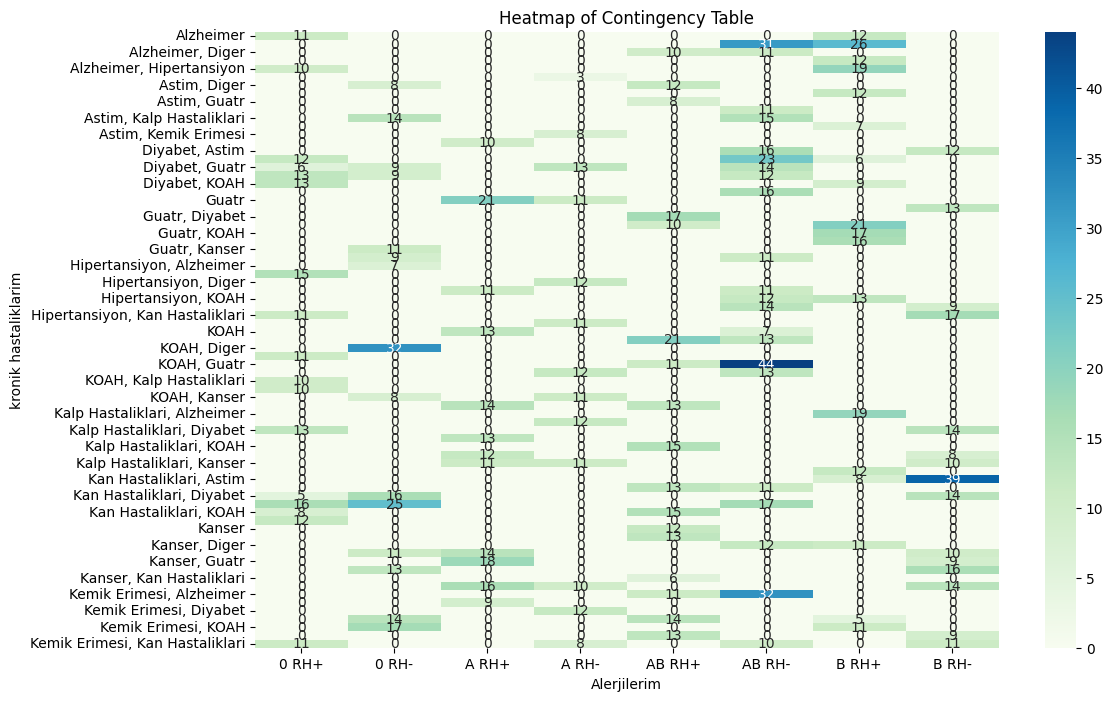

In [45]:
plot_contingency_table(contingency_table)

In [46]:
def check_missingness_random(df, target_column):
    """
    Check if missingness in the target column is random.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    target_column (str): The name of the target column to analyze for missingness.

    Returns:
    dict: A dictionary with test statistics and p-value for each column.
    """
    # Check if target_column exists in the DataFrame
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in DataFrame.")

    # Create a mask for missing and non-missing values
    missing_mask = df[target_column].isnull()

    # Identify other columns for comparison
    other_columns = df.columns[df.columns != target_column]

    results = {}

    for col in other_columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df[col]):
            try:
                # Perform t-test between missing and non-missing groups
                group_missing = df.loc[missing_mask, col].dropna()
                group_non_missing = df.loc[~missing_mask, col].dropna()

                if len(group_missing) > 0 and len(group_non_missing) > 0:
                    t_stat, p_value = stats.ttest_ind(group_missing, group_non_missing, equal_var=False)
                    results[col] = {
                        't_stat': t_stat,
                        'p_value': p_value
                    }
                else:
                    results[col] = {'message': 'Not enough data for comparison.'}
            except Exception as e:
                results[col] = {'error': str(e)}
        else:
            results[col] = {'message': f"Column '{col}' is not numeric."}

    return results
check_missingness_random(df,"Il")

{'Kullanici_id': {'t_stat': 2.0427764354760582,
  'p_value': 0.04210432234588537},
 'Cinsiyet': {'message': "Column 'Cinsiyet' is not numeric."},
 'Dogum_Tarihi': {'message': "Column 'Dogum_Tarihi' is not numeric."},
 'Uyruk': {'message': "Column 'Uyruk' is not numeric."},
 'Ilac_Adi': {'message': "Column 'Ilac_Adi' is not numeric."},
 'Ilac_Baslangic_Tarihi': {'message': "Column 'Ilac_Baslangic_Tarihi' is not numeric."},
 'Ilac_Bitis_Tarihi': {'message': "Column 'Ilac_Bitis_Tarihi' is not numeric."},
 'Yan_Etki': {'message': "Column 'Yan_Etki' is not numeric."},
 'Yan_Etki_Bildirim_Tarihi': {'message': "Column 'Yan_Etki_Bildirim_Tarihi' is not numeric."},
 'Alerjilerim': {'message': "Column 'Alerjilerim' is not numeric."},
 'Kronik Hastaliklarim': {'message': "Column 'Kronik Hastaliklarim' is not numeric."},
 'Baba Kronik Hastaliklari': {'message': "Column 'Baba Kronik Hastaliklari' is not numeric."},
 'Anne Kronik Hastaliklari': {'message': "Column 'Anne Kronik Hastaliklari' is not n

In [48]:
df.head()

Kullanici_id Cinsiyet Dogum_Tarihi    Uyruk         Il  \
0           107    Erkek   1960-03-01  Turkiye  Canakkale   
1           140    Erkek   1939-10-12  Turkiye    Trabzon   
2             2    Kadin   1976-12-17  Turkiye  Canakkale   
3            83    Erkek   1977-06-17  Turkiye      Adana   
4             7    Kadin   1976-09-03  Turkiye      Izmir   

                         Ilac_Adi Ilac_Baslangic_Tarihi Ilac_Bitis_Tarihi  \
0                 trifluoperazine            2022-01-09        2022-03-04   
1                fluphenazine hcl            2022-01-09        2022-03-08   
2                 warfarin sodium            2022-01-11        2022-03-12   
3                   valproic acid            2022-01-04        2022-03-12   
4  carbamazepine extended release            2022-01-13        2022-03-06   

                Yan_Etki Yan_Etki_Bildirim_Tarihi Alerjilerim  \
0               Kabizlik      2022-02-19 18:28:43       Ceviz   
1              Yorgunluk      2022-02-03 20:48:17         Toz   
2               Carpinti      2022-02-04 05:29:20         Muz   
3             Sinirlilik      2022-02-08 01:01:21      Pancar   
4  Agizda Farkli Bir Tat      2022-02-12 05:33:06         NaN   

              Kronik Hastaliklarim  Baba Kronik Hastaliklari  \
0  Hipertansiyon, Kan Hastaliklari      Guatr, Hipertansiyon   
1                              NaN              Guatr, Diger   
2       Kalp Hastaliklari, Diyabet             Diyabet, KOAH   
3                   Diyabet, Diger  Kalp Hastaliklari, Diger   
4       Diyabet, Kalp Hastaliklari  Alzheimer, Hipertansiyon   

           Anne Kronik Hastaliklari    Kiz Kardes Kronik Hastaliklari  \
0                              KOAH  Kemik Erimesi, Kalp Hastaliklari   
1  Hipertansiyon, Kalp Hastaliklari                                     
2            Kemik Erimesi, Diyabet            Diyabet, Kemik Erimesi   
3                               NaN                             Astim   
4   Kan Hastaliklari, Kemik Erimesi                    Diyabet, Diger   

  Erkek Kardes Kronik Hastaliklari Kan Grubu   Kilo    Boy  Sure  
0             Kemik Erimesi, Guatr     B RH-  103.0  191.0    54  
1                    KOAH, Diyabet       NaN   81.0  181.0    58  
2                            Diger     B RH-   93.0  158.0    60  
3        Kalp Hastaliklari, Kanser    AB RH-    NaN  165.0    67  
4         Alzheimer, Hipertansiyon    AB RH-   99.0  172.0    52

In [49]:
df_second = df.copy()

In [50]:
df = pd.get_dummies(df, columns=cat_cols)

In [51]:
df = pd.get_dummies(df, columns = cat_but_car)

In [52]:
df = df.drop(columns=df.select_dtypes(include=['datetime64']).columns)

In [53]:
df.loc[:, df.dtypes == 'bool'] = df.loc[:, df.dtypes == 'bool'].astype(int)

In [54]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [55]:
df = df.loc[:, ~df.columns.duplicated()]

In [56]:
# Initialize the MissForest imputer
imputer = MissForest()
df_imputed = imputer.fit_transform(df)

 60%|██████    | 3/5 [00:02<00:01,  1.15it/s]


In [57]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Columns: 656 entries, Kullanici_id to ErkekKardesKronikHastaliklari_KemikErimesiKanHastaliklari
dtypes: float64(2), int64(654)
memory usage: 11.8 MB


In [58]:
df_checkpoint = df_imputed.copy()

<Axes: >

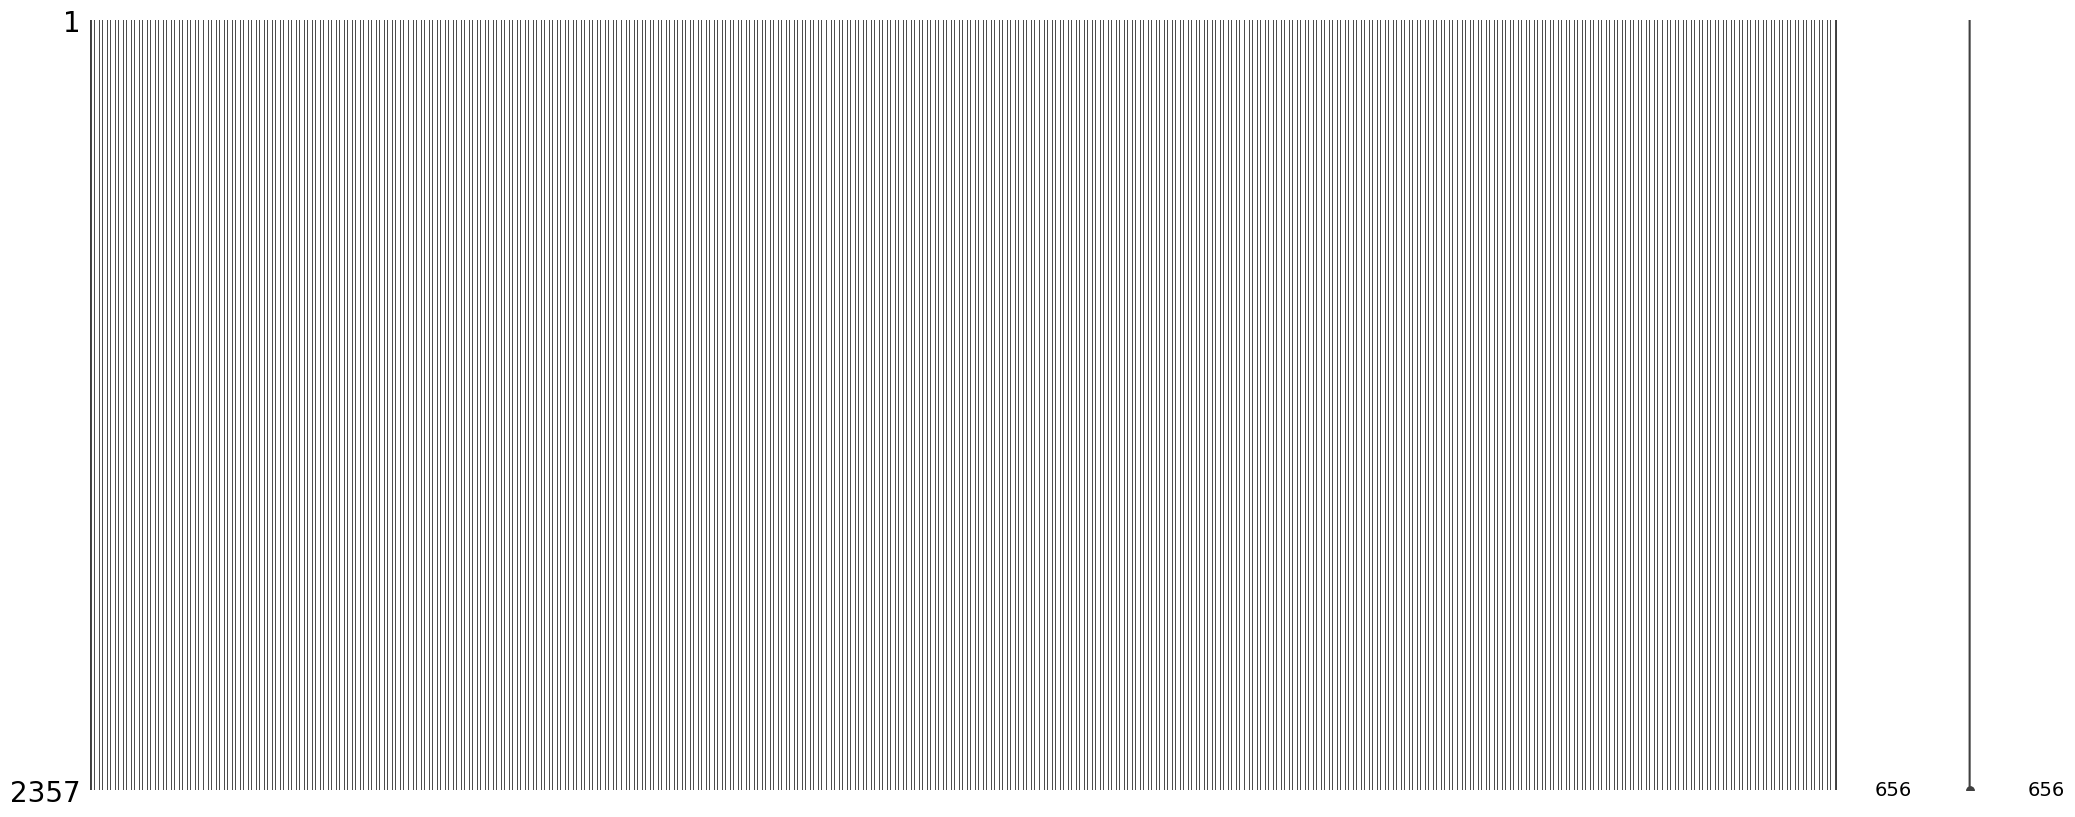

In [59]:
msno.matrix(df_imputed)

In [60]:
df = df.reset_index(drop=True)

In [61]:
df.head()

Kullanici_id   Kilo    Boy  Sure  Cinsiyet_Erkek  Cinsiyet_Kadin  \
0           107  103.0  191.0    54               1               0   
1           140   81.0  181.0    58               1               0   
2             2   93.0  158.0    60               0               1   
3            83    NaN  165.0    67               1               0   
4             7   99.0  172.0    52               0               1   

   Uyruk_Turkiye  Il_Adana  Il_Ankara  Il_Antalya  ...  \
0              1         0          0           0  ...   
1              1         0          0           0  ...   
2              1         0          0           0  ...   
3              1         1          0           0  ...   
4              1         0          0           0  ...   

   ErkekKardesKronikHastaliklari_KanserKemikErimesi  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   ErkekKardesKronikHastaliklari_KemikErimesi  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   ErkekKardesKronikHastaliklari_KemikErimesiAlzheimer  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   ErkekKardesKronikHastaliklari_KemikErimesiDiger  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   ErkekKardesKronikHastaliklari_KemikErimesiDiyabet  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   ErkekKardesKronikHastaliklari_KemikErimesiGuatr  \
0                                                1   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   ErkekKardesKronikHastaliklari_KemikErimesiHipertansiyon  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ErkekKardesKronikHastaliklari_KemikErimesiKOAH  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   ErkekKardesKronikHastaliklari_KemikErimesiKalpHastaliklari  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   ErkekKardesKronikHastaliklari_KemikErimesiKanHastaliklari  
0                                                  0          
1                                                  0    

In [62]:
from sklearn.preprocessing import StandardScaler

def scale_specific_columns(df, columns_to_scale):
    # Create a copy of the DataFrame to avoid modifying the original
    df_scaled = df.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Scale only the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

    return df_scaled


In [63]:
columns_to_scale = ['Kilo', 'Boy', 'Sure']
scaled_df = scale_specific_columns(df, columns_to_scale)


In [64]:
scaled_df.head()

Kullanici_id      Kilo       Boy      Sure  Cinsiyet_Erkek  Cinsiyet_Kadin  \
0           107  1.188151  0.990837 -1.252373               1               0   
1           140  0.007307  0.385249 -0.644028               1               0   
2             2  0.651404 -1.007604 -0.339855               0               1   
3            83       NaN -0.583692  0.724749               1               0   
4             7  0.973452 -0.159780 -1.556545               0               1   

   Uyruk_Turkiye  Il_Adana  Il_Ankara  Il_Antalya  ...  \
0              1         0          0           0  ...   
1              1         0          0           0  ...   
2              1         0          0           0  ...   
3              1         1          0           0  ...   
4              1         0          0           0  ...   

   ErkekKardesKronikHastaliklari_KanserKemikErimesi  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   ErkekKardesKronikHastaliklari_KemikErimesi  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   ErkekKardesKronikHastaliklari_KemikErimesiAlzheimer  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   ErkekKardesKronikHastaliklari_KemikErimesiDiger  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   ErkekKardesKronikHastaliklari_KemikErimesiDiyabet  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   ErkekKardesKronikHastaliklari_KemikErimesiGuatr  \
0                                                1   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   ErkekKardesKronikHastaliklari_KemikErimesiHipertansiyon  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ErkekKardesKronikHastaliklari_KemikErimesiKOAH  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   ErkekKardesKronikHastaliklari_KemikErimesiKalpHastaliklari  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   ErkekKardesKronikHastaliklari_KemikErimesiKanHastaliklari  
0                                                  0       

In [65]:
df_final = scaled_df.copy()

In [66]:
df_second.head()

Kullanici_id Cinsiyet Dogum_Tarihi    Uyruk         Il  \
0           107    Erkek   1960-03-01  Turkiye  Canakkale   
1           140    Erkek   1939-10-12  Turkiye    Trabzon   
2             2    Kadin   1976-12-17  Turkiye  Canakkale   
3            83    Erkek   1977-06-17  Turkiye      Adana   
4             7    Kadin   1976-09-03  Turkiye      Izmir   

                         Ilac_Adi Ilac_Baslangic_Tarihi Ilac_Bitis_Tarihi  \
0                 trifluoperazine            2022-01-09        2022-03-04   
1                fluphenazine hcl            2022-01-09        2022-03-08   
2                 warfarin sodium            2022-01-11        2022-03-12   
3                   valproic acid            2022-01-04        2022-03-12   
4  carbamazepine extended release            2022-01-13        2022-03-06   

                Yan_Etki Yan_Etki_Bildirim_Tarihi Alerjilerim  \
0               Kabizlik      2022-02-19 18:28:43       Ceviz   
1              Yorgunluk      2022-02-03 20:48:17         Toz   
2               Carpinti      2022-02-04 05:29:20         Muz   
3             Sinirlilik      2022-02-08 01:01:21      Pancar   
4  Agizda Farkli Bir Tat      2022-02-12 05:33:06         NaN   

              Kronik Hastaliklarim  Baba Kronik Hastaliklari  \
0  Hipertansiyon, Kan Hastaliklari      Guatr, Hipertansiyon   
1                              NaN              Guatr, Diger   
2       Kalp Hastaliklari, Diyabet             Diyabet, KOAH   
3                   Diyabet, Diger  Kalp Hastaliklari, Diger   
4       Diyabet, Kalp Hastaliklari  Alzheimer, Hipertansiyon   

           Anne Kronik Hastaliklari    Kiz Kardes Kronik Hastaliklari  \
0                              KOAH  Kemik Erimesi, Kalp Hastaliklari   
1  Hipertansiyon, Kalp Hastaliklari                                     
2            Kemik Erimesi, Diyabet            Diyabet, Kemik Erimesi   
3                               NaN                             Astim   
4   Kan Hastaliklari, Kemik Erimesi                    Diyabet, Diger   

  Erkek Kardes Kronik Hastaliklari Kan Grubu   Kilo    Boy  Sure  
0             Kemik Erimesi, Guatr     B RH-  103.0  191.0    54  
1                    KOAH, Diyabet       NaN   81.0  181.0    58  
2                            Diger     B RH-   93.0  158.0    60  
3        Kalp Hastaliklari, Kanser    AB RH-    NaN  165.0    67  
4         Alzheimer, Hipertansiyon    AB RH-   99.0  172.0    52